In [1]:
import numpy as np
from scipy import signal
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from natsort import natsorted
import pandas as pd
from scipy.signal import butter, lfilter, freqz, filtfilt
from scipy.special import erfc



import matplotlib.pyplot as plt
plt.style.use('../../style.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
import sys
sys.path.insert(0,'../../../purity-monitor/')
sys.path.insert(0,'../../WaveformAnalysis')

In [3]:
import Dataset as Dataset
import StandMonitor as Monitor
import PlotFunctions as Plt
import Waveform as Waveform
import SiPM as SiPM

In [4]:
import importlib
importlib.reload(Dataset)
importlib.reload(Monitor)
importlib.reload(Plt)
importlib.reload(SiPM)

<module 'SiPM' from '../../../purity-monitor/SiPM.py'>

In [5]:
data_vacuum = SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/', 
                    Selection='*DCR_30V*.h5')
data_vacuum.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

for i,File in enumerate(natsorted(data_vacuum.Files)):

    print(i,File)
#     print('Getting data...')
    data_vacuum.ImportDataFromHDF5(File, data_vacuum.Ch)

    
data_GXe = SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211201/', 
                    Selection='*DCR_30V*.h5')
data_GXe.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

for i,File in enumerate(natsorted(data_GXe.Files)):

    print(i,File)
#     print('Getting data...')
    data_GXe.ImportDataFromHDF5(File, data_GXe.Ch)

    
vacuum_freq=1/(100e-3*100*len(natsorted(data_vacuum.Files)))
GXe_freq=1/(100e-3*100*len(natsorted(data_GXe.Files)))

0 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_30V_0.h5
1 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_30V_1.h5
2 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_30V_2.h5
3 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_30V_3.h5
4 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_30V_4.h5
5 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_30V_5.h5
6 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_30V_6.h5
7 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_30V_7.h5
8 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_30V_8.h5
9 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_30V_9.h5
10 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_30V_10.h5
11 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203

In [6]:
def butterfilter(data,time,scale,order,lowfreq,highfreq,band_type):
    filtered_amp=[]
    fs=1/(np.mean(np.diff(time))/scale)
    nyq=0.5*fs
    b, a = butter(order, [lowfreq/nyq, highfreq/nyq], btype=band_type, analog=False)
    for ii,amp in enumerate(data):
        filtamp = filtfilt(b,a,amp)
        filtered_amp.append(filtamp)
    return filtered_amp


In [7]:
def peak_integral(Height,Distance):
    peak_integral_1=[]
    peak_integral_5=[]
    peak_integral_10=[]
    peak_integral_100=[]
    peak_integral_200=[]
    peak_height=[]
    for filt_waveform in butterfilter(data,time,scale,order,lowfreq,highfreq,band_type):
        peaks,pdict=find_peaks(filt_waveform,height=Height,distance=Distance)
        peak_height.extend(pdict['peak_heights'])
        for peak_index in peaks:
            peak_integral_1.append((np.abs(np.sum(filt_waveform[peak_index-1:peak_index+1]))))
            peak_integral_5.append((np.abs(np.sum(filt_waveform[peak_index-1:peak_index+5]))))
            peak_integral_10.append((np.abs(np.sum(filt_waveform[peak_index-1:peak_index+10]))))
            peak_integral_100.append((np.abs(np.sum(filt_waveform[peak_index-1:peak_index+100]))))
            peak_integral_200.append((np.abs(np.sum(filt_waveform[peak_index-1:peak_index+200]))))
            
    return peak_integral_10

In [8]:
def func(x,base,V0,sigma,tau,mu):
    return base + V0/2.0 * np.exp(0.5 * (sigma/tau)**2 - (x-mu)/tau) * erfc(1.0/np.sqrt(2.0) * (sigma/tau - (x-mu)/sigma))
    
def gauss_conv(x, mu=0, sigma=0.1):
    x = x-mu
    return np.exp(-np.square((x-mu)/sigma)/2)/(sigma*np.sqrt(2*np.pi))

In [9]:
# Returns the discrete, linear convolution of two one-dimensional sequences.
def convolution(sampling_time,mode):
    convol_list=[]
    desire_x = np.arange(-500,500, sampling_time)
    desire_y = gauss_conv(desire_x)
    desire_f = np.fft.fft(desire_y)

    resp_x = np.arange(0,1000, sampling_time)
    resp_y = func(resp_x, 0, 1, 1.83, 46.93, 0)
    resp_f = np.fft.fft(resp_y)

    filter_f = desire_f/resp_f
    filter_y = np.real(np.fft.ifft(filter_f))
    

    for ii,vals in enumerate(butterfilter(data,time,scale,order,lowfreq,highfreq,band_type)):
        convol=np.convolve(vals,filter_y,mode)
        convol_list.append(convol)
    return convol_list


In [10]:
def peak_finding(Height,Distance):
    peak_height_gain=[]
    for ii,vals in enumerate(convolution(sampling_time,mode)):
        peaks_gain,pdict_gain=find_peaks(vals,height=Height,distance=Distance)
        if len(peaks_gain)>0:
            peak_height_gain.extend(pdict_gain['peak_heights'])
    return peak_height_gain

In [11]:
data=data_vacuum.Ch[0].Amp
time=data_vacuum.Ch[0].Time
scale=data_vacuum.Ch[0].TScale
order=3
lowfreq=100
highfreq=100000
band_type='band'
sampling_time=data_vacuum.Ch[0].Time[1]-data_vacuum.Ch[0].Time[0]
mode='same'
Height=20
Distance=1

In [12]:
peak_heights_vacuum=peak_finding(Height,Distance)

peak_integral_vacuum=peak_integral(Height,Distance)

h_vacuum,hx_vacuum = np.histogram(peak_heights_vacuum, bins=np.arange(0,300,1))

h_vacuum_integral,hx_vacuum_integral = np.histogram(peak_integral_vacuum, bins=np.linspace(0,1000,150))


pe_vacuum = np.median(peak_heights_vacuum)

median_integral_vacuum=np.median(peak_integral_vacuum)


gain_list_vacuum=[]
gain_err_list_vacuum=[]
ca_list_vacuum=[]
Yale_ca_err_vacuum=[]
Yale_ca_RMS_vacuum=[]


integral_list_vacuum=[]
integral_err_list_vacuum=[]
ca_list_vacuum_integral=[]
Yale_ca_err_vacuum_integral=[]
Yale_ca_RMS_vacuum_integral=[]

In [13]:
data=data_GXe.Ch[0].Amp
time=data_GXe.Ch[0].Time
scale=data_GXe.Ch[0].TScale
order=3
lowfreq=100
highfreq=100000
band_type='band'
sampling_time=data_GXe.Ch[0].Time[1]-data_GXe.Ch[0].Time[0]
mode='same'
Height=20
Distance=1

In [14]:
peak_heights_GXe=peak_finding(Height,Distance)

h_GXe,hx_GXe = np.histogram(peak_heights_GXe, bins=np.arange(0,300,1))
pe_GXe = np.median(peak_heights_GXe)

gain_list_GXe=[]
gain_err_list_GXe=[]
ca_list_GXe=[]
Yale_ca_err_GXe=[]
Yale_ca_RMS_GXe=[]


peak_integral_GXe=peak_integral(Height,Distance)

h_GXe_integral,hx_GXe_integral = np.histogram(peak_integral_GXe, bins=np.linspace(0,1000,150))

median_integral_GXe=np.median(peak_integral_GXe)

integral_list_GXe=[]
integral_err_list_GXe=[]
ca_list_GXe_integral=[]
Yale_ca_err_GXe_integral=[]
Yale_ca_RMS_GXe_integral=[]

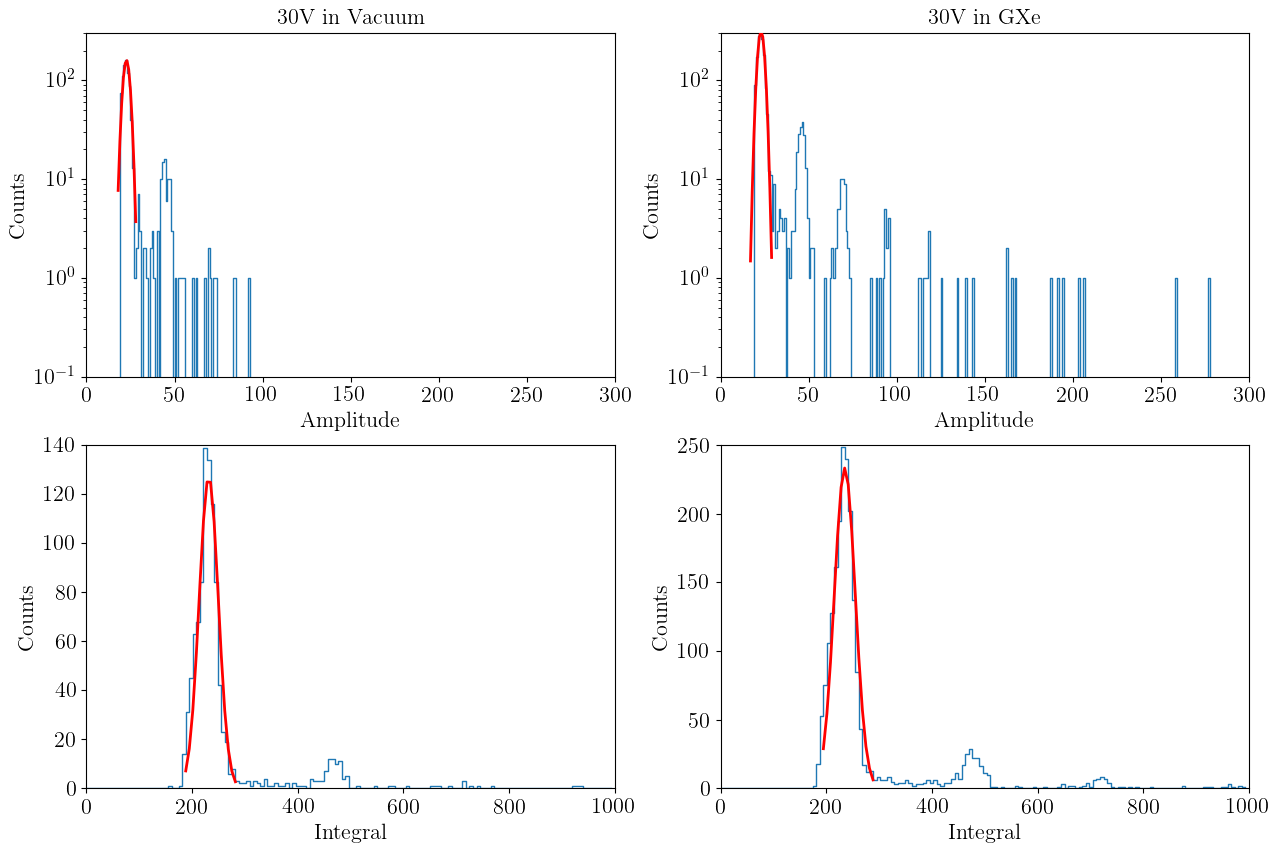

In [15]:
def gauss_func(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))



plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
for i in range(1,2):
    cut_vacuum = np.where((hx_vacuum[:-1]>pe_vacuum*i-6) & (hx_vacuum[:-1]<pe_vacuum*i+(5/i)))
    
    popt_vacuum,pcov_vacuum = curve_fit(gauss_func, hx_vacuum[:-1][cut_vacuum], h_vacuum[cut_vacuum], 
                          p0=[np.max(h_vacuum[cut_vacuum]), pe_vacuum*i,10],maxfev=100000)

    plt.plot(hx_vacuum[:-1][cut_vacuum], gauss_func(hx_vacuum[:-1][cut_vacuum], *popt_vacuum), color='r', zorder=10)
    plt.step(hx_vacuum[:-1], h_vacuum, lw=1)
    plt.xlabel('Amplitude')
    plt.ylabel('Counts')
    plt.yscale('log')
    plt.ylim(0.1,300)
    plt.title('30V in Vacuum')
plt.subplot(2,2,2)
for i in range(1,2):
    cut_GXe = np.where((hx_GXe[:-1]>pe_GXe*i-8) & (hx_GXe[:-1]<pe_GXe*i+(5/i)))
    
    popt_GXe,pcov_GXe = curve_fit(gauss_func, hx_GXe[:-1][cut_GXe], h_GXe[cut_GXe], 
                          p0=[np.max(h_GXe[cut_GXe]), pe_GXe*i,10],maxfev=100000)

    plt.plot(hx_GXe[:-1][cut_GXe], gauss_func(hx_GXe[:-1][cut_GXe], *popt_GXe), color='r', zorder=10)
    plt.step(hx_GXe[:-1], h_GXe, lw=1)
    plt.xlabel('Amplitude')
    plt.ylabel('Counts')
    plt.yscale('log')
    plt.ylim(0.1,300)
    plt.title('30V in GXe')

plt.subplot(2,2,3)

BINS=np.linspace(0,1000,100)
cut_vacuum_integral=np.where((hx_vacuum_integral[:-1]<median_integral_vacuum+50) & (hx_vacuum_integral[:-1]>median_integral_vacuum-50))
# plt.hist(peak_integral_10,bins=BINS,lw=1,histtype='step',label='-1 $\mu$s to 10 $\mu$s')
popt_vacuum_integral,pcov_vacuum_integral=curve_fit(gauss_func,hx_vacuum_integral[:-1][:-1][cut_vacuum_integral],h_vacuum_integral[:-1][cut_vacuum_integral],p0=[np.max(h_vacuum_integral[:-1][cut_vacuum_integral]),median_integral_vacuum,10],maxfev=100000)
plt.plot(hx_vacuum_integral[:-1][cut_vacuum_integral],gauss_func(hx_vacuum_integral[:-1][cut_vacuum_integral],*popt_vacuum_integral),color='r', zorder=10)
plt.step(hx_vacuum_integral[:-1], h_vacuum_integral, lw=1)
plt.xlabel('Integral')
plt.ylabel('Counts')




plt.subplot(2,2,4)

cut_GXe_integral=np.where((hx_GXe_integral[:-1]<median_integral_GXe+50) & (hx_GXe_integral[:-1]>median_integral_GXe-50))
# plt.hist(peak_integral_10,bins=BINS,lw=1,histtype='step',label='-1 $\mu$s to 10 $\mu$s')
popt_GXe_integral,pcov_GXe_integral=curve_fit(gauss_func,hx_GXe_integral[:-1][:-1][cut_GXe_integral],h_GXe_integral[:-1][cut_GXe_integral],p0=[np.max(h_GXe_integral[:-1][cut_GXe_integral]),median_integral_GXe,10],maxfev=100000)
plt.plot(hx_GXe_integral[:-1][cut_GXe_integral],gauss_func(hx_GXe_integral[:-1][cut_GXe_integral],*popt_GXe_integral),color='r', zorder=10)
plt.step(hx_GXe_integral[:-1], h_GXe_integral, lw=1)
plt.xlabel('Integral')
plt.ylabel('Counts')




plt.show()




gain_vacuum=popt_vacuum[1]
gain_list_vacuum.append(gain_vacuum)
gain_err_vacuum=np.sqrt(np.diag(pcov_vacuum))
gain_err_list_vacuum.append(gain_err_vacuum[1])

gain_GXe=popt_GXe[1]
gain_list_GXe.append(gain_GXe)
gain_err_GXe=np.sqrt(np.diag(pcov_GXe))
gain_err_list_GXe.append(gain_err_GXe[1])



first_integral_vacuum=popt_vacuum_integral[1]
integral_list_vacuum.append(first_integral_vacuum)
integral_err_vacuum=np.sqrt(np.diag(pcov_vacuum_integral))
integral_err_list_vacuum.append(integral_err_vacuum[1])
  

first_integral_GXe=popt_GXe_integral[1]
integral_list_GXe.append(first_integral_GXe)
integral_err_GXe=np.sqrt(np.diag(pcov_GXe_integral))
integral_err_list_GXe.append(integral_err_GXe[1])


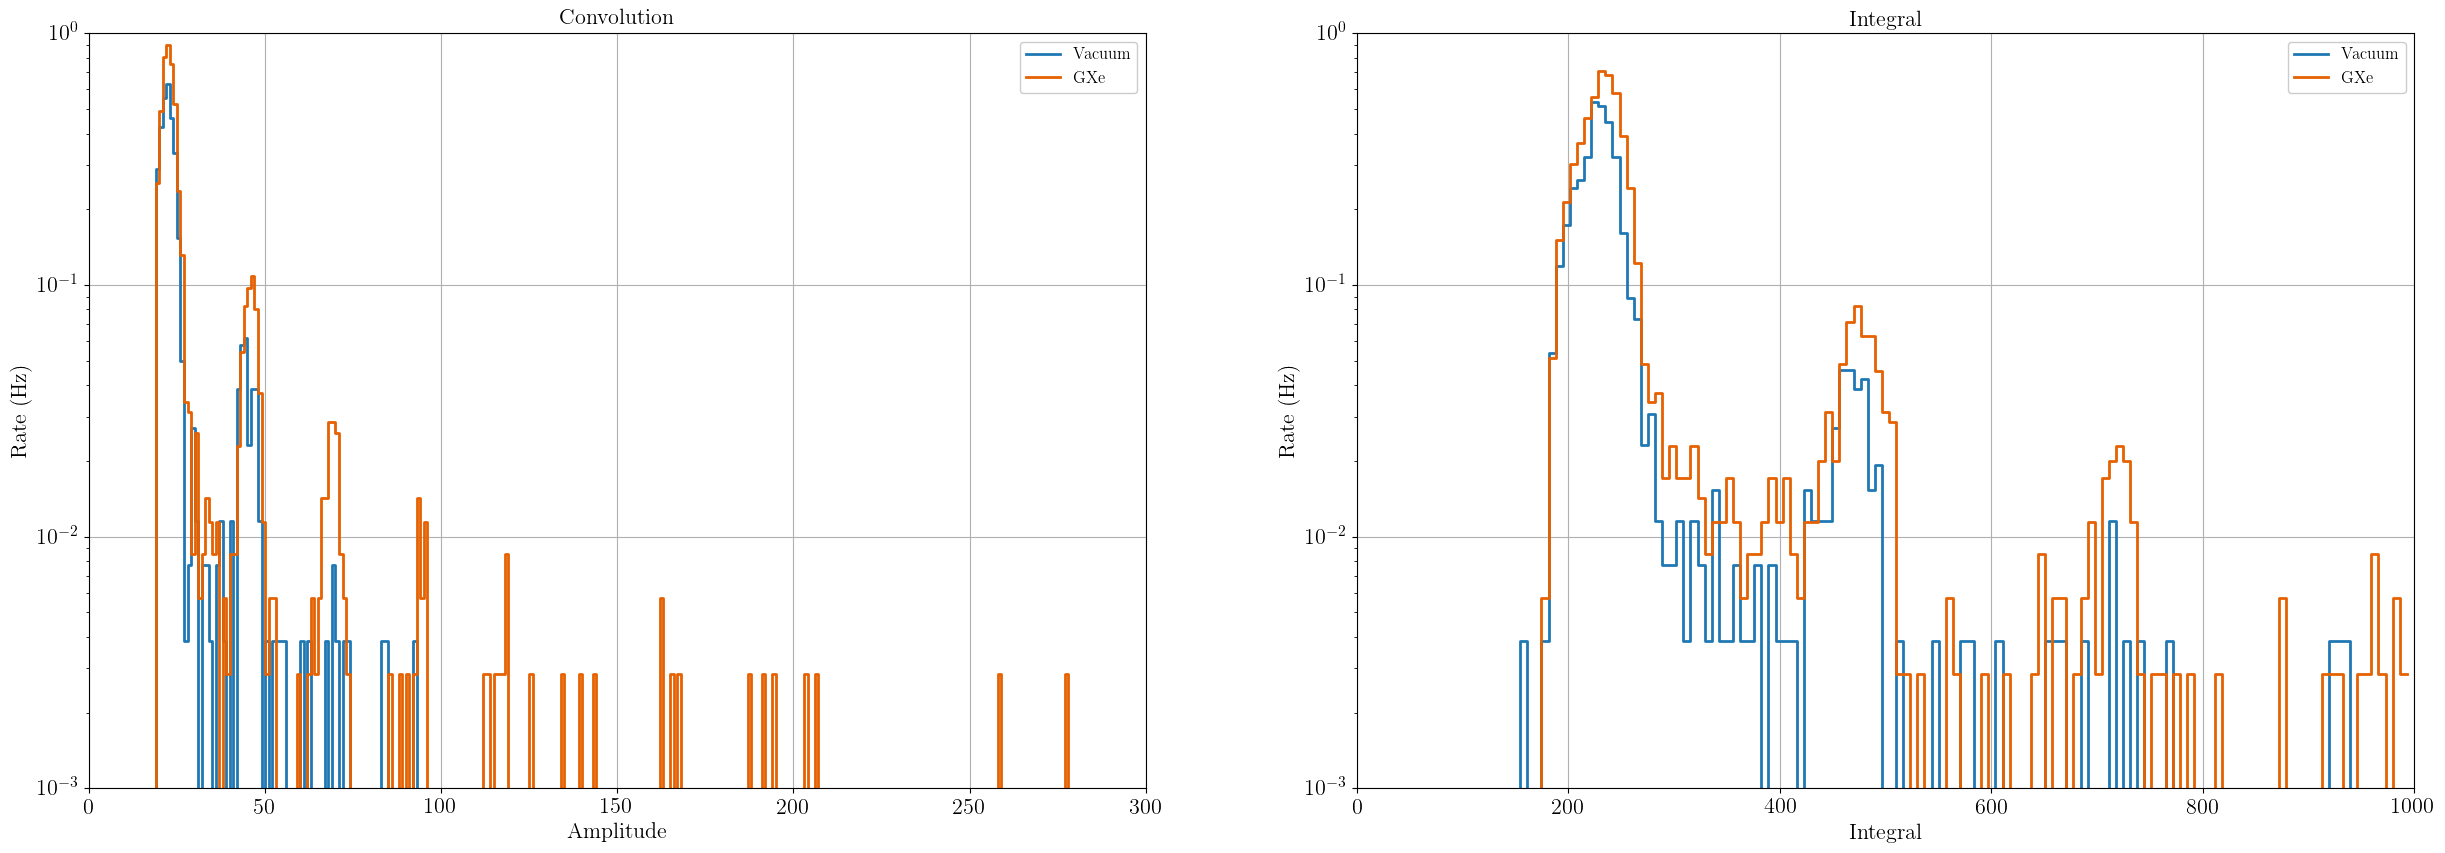

In [16]:
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.step(hx_vacuum[:-1], h_vacuum*vacuum_freq, lw=2,label='Vacuum')
plt.step(hx_GXe[:-1], h_GXe*GXe_freq, lw=2,label='GXe')
plt.xlabel('Amplitude')
plt.ylabel('Rate (Hz)')
plt.yscale('log')
plt.title('Convolution')
plt.grid()
plt.legend(loc=1)


plt.subplot(1,2,2)
plt.step(hx_vacuum_integral[:-1], h_vacuum_integral*vacuum_freq, lw=2,label='Vacuum')
plt.step(hx_GXe_integral[:-1], h_GXe_integral*GXe_freq, lw=2,label='GXe')
plt.xlabel('Integral')
plt.ylabel('Rate (Hz)')
plt.title('Integral')
plt.grid()
plt.legend(loc=1)
plt.yscale('log')

plt.show()

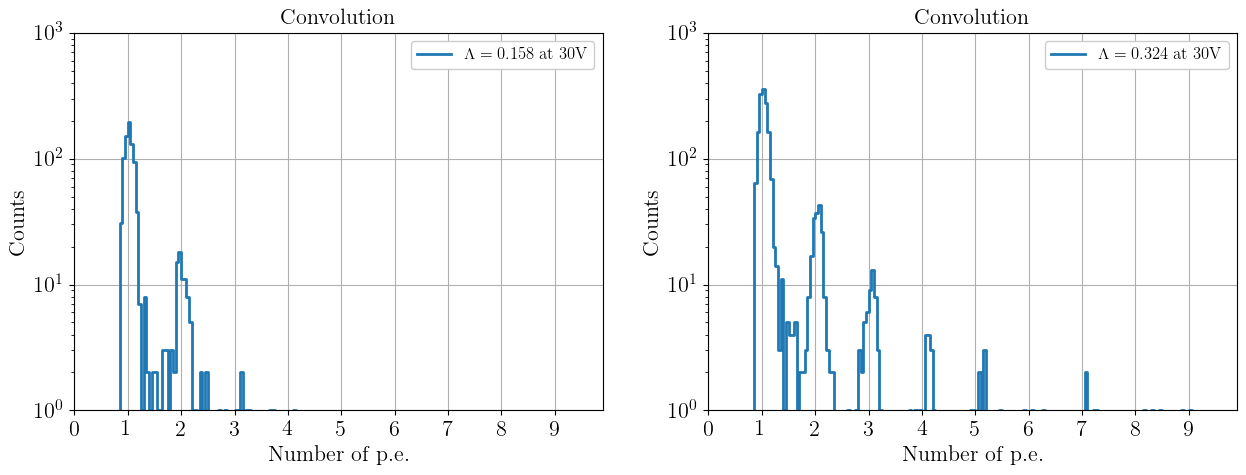

In [17]:
peak_height_calib_vacuum = np.array(peak_heights_vacuum)/np.mean(gain_vacuum)
ca_vacuum = (np.mean(peak_height_calib_vacuum) - 1)
ca_list_vacuum.append(ca_vacuum)
Yale_ca_RMS_vacuum.append(np.sqrt(np.mean(np.square(peak_height_calib_vacuum)))-1)
Yale_ca_err_vacuum.append(np.std(peak_height_calib_vacuum)/np.sqrt(len(peak_height_calib_vacuum)))


peak_height_calib_GXe = np.array(peak_heights_GXe)/np.mean(gain_GXe)
ca_GXe = (np.mean(peak_height_calib_GXe) - 1)
ca_list_GXe.append(ca_GXe)
Yale_ca_RMS_GXe.append(np.sqrt(np.mean(np.square(peak_height_calib_GXe)))-1)
Yale_ca_err_GXe.append(np.std(peak_height_calib_GXe)/np.sqrt(len(peak_height_calib_GXe)))


h_vacuum,hx_vacuum = np.histogram(peak_height_calib_vacuum, bins=np.arange(0,10,0.05))

h_GXe,hx_GXe = np.histogram(peak_height_calib_GXe, bins=np.arange(0,10,0.05))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx_vacuum[:-1], h_vacuum, lw=2, where='post', label='$\Lambda={:.3f}$ at 30V'.format(ca_vacuum))
plt.legend(loc='upper right')
plt.title('Convolution')
plt.subplot(1,2,2)
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx_GXe[:-1], h_GXe, lw=2, where='post', label='$\Lambda={:.3f}$ at 30V'.format(ca_GXe))
plt.legend(loc='upper right')
plt.title('Convolution')
plt.show()


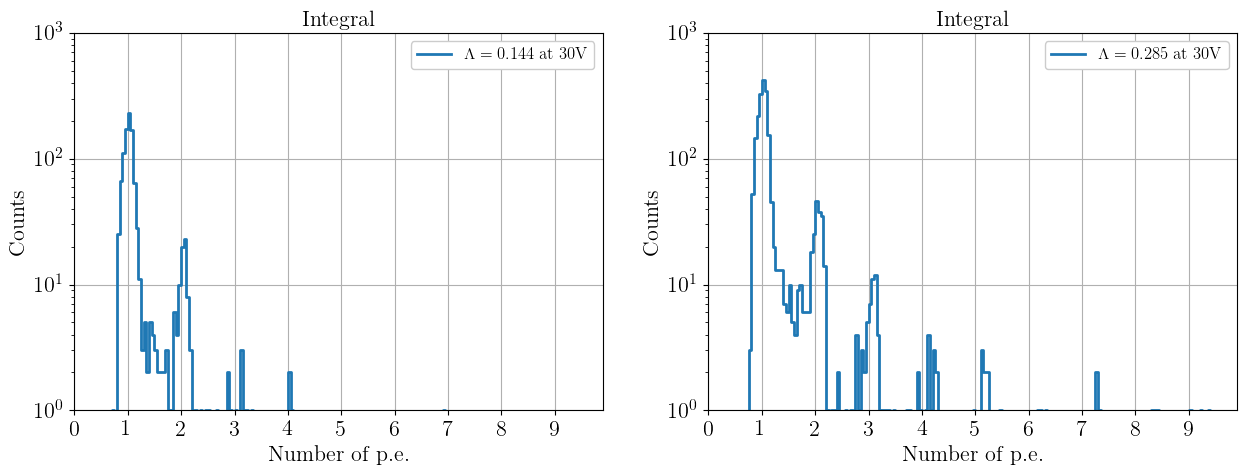

In [18]:
peak_integral_calib_vacuum = np.array(peak_integral_vacuum)/(first_integral_vacuum)
ca_vacuum_integral = (np.mean(peak_integral_calib_vacuum) - 1)
ca_list_vacuum_integral.append(ca_vacuum_integral)
Yale_ca_RMS_vacuum_integral.append(np.sqrt(np.mean(np.square(peak_integral_calib_vacuum)))-1)
Yale_ca_err_vacuum_integral.append(np.std(peak_integral_calib_vacuum)/np.sqrt(len(peak_integral_calib_vacuum)))


peak_integral_calib_GXe = np.array(peak_integral_GXe)/(first_integral_GXe)
ca_GXe_integral = (np.mean(peak_integral_calib_GXe) - 1)
ca_list_GXe_integral.append(ca_GXe_integral)
Yale_ca_RMS_GXe_integral.append(np.sqrt(np.mean(np.square(peak_integral_calib_GXe)))-1)
Yale_ca_err_GXe_integral.append(np.std(peak_integral_calib_GXe)/np.sqrt(len(peak_integral_calib_GXe)))


h_vacuum_integral,hx_vacuum_integral = np.histogram(peak_integral_calib_vacuum, bins=np.arange(0,10,0.05))

h_GXe_integral,hx_GXe_integral = np.histogram(peak_integral_calib_GXe, bins=np.arange(0,10,0.05))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx_vacuum_integral[:-1], h_vacuum_integral, lw=2, where='post', label='$\Lambda={:.3f}$ at 30V'.format(ca_vacuum_integral))
plt.legend(loc='upper right')
plt.title('Integral')
plt.subplot(1,2,2)
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx_GXe_integral[:-1], h_GXe_integral, lw=2, where='post', label='$\Lambda={:.3f}$ at 30V'.format(ca_GXe_integral))
plt.legend(loc='upper right')
plt.title('Integral')
plt.show()


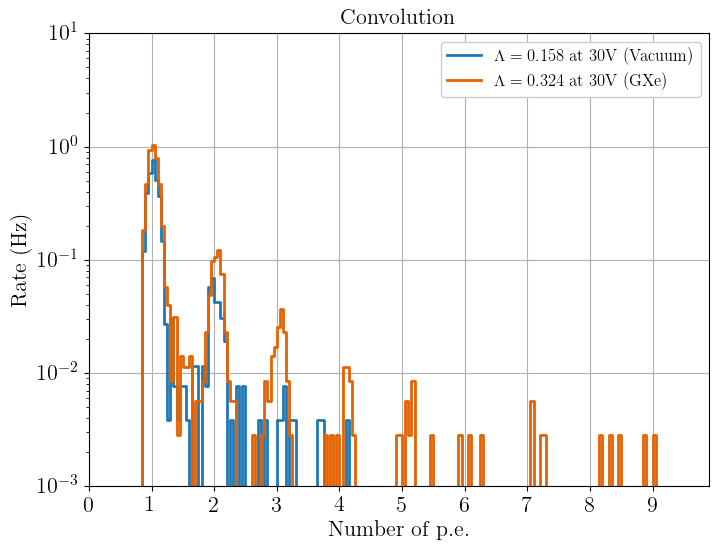

In [19]:
plt.figure(figsize=(8,6))
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Rate (Hz)')
plt.yscale('log')
plt.step(hx_vacuum[:-1], h_vacuum*vacuum_freq, lw=2, where='post', label='$\Lambda={:.3f}$ at 30V (Vacuum)'.format(ca_vacuum))
plt.step(hx_GXe[:-1], h_GXe*GXe_freq, lw=2, where='post', label='$\Lambda={:.3f}$ at 30V (GXe)'.format(ca_GXe))
plt.legend(loc='upper right')
plt.title('Convolution')
plt.show()

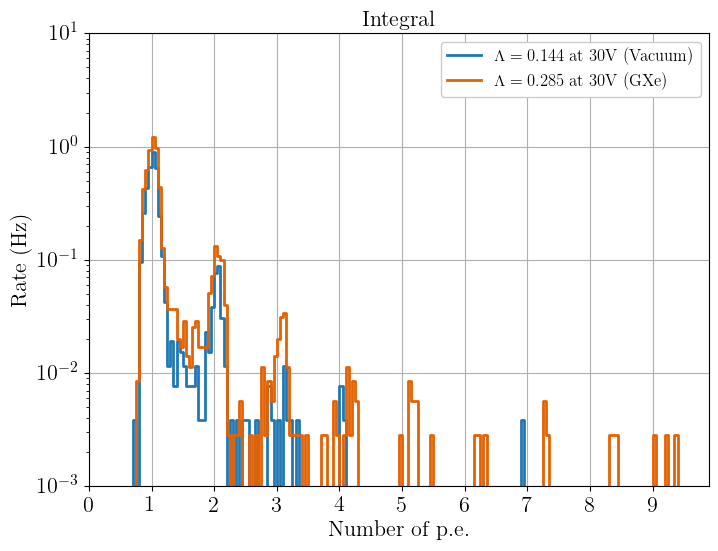

In [20]:
plt.figure(figsize=(8,6))
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Rate (Hz)')
plt.yscale('log')
plt.title('Integral')
plt.step(hx_vacuum_integral[:-1], h_vacuum_integral*vacuum_freq, lw=2, where='post', label='$\Lambda={:.3f}$ at 30V (Vacuum)'.format(ca_vacuum_integral))
plt.step(hx_GXe_integral[:-1], h_GXe_integral*GXe_freq, lw=2, where='post', label='$\Lambda={:.3f}$ at 30V (GXe)'.format(ca_GXe_integral))
plt.legend(loc='upper right')
plt.show()

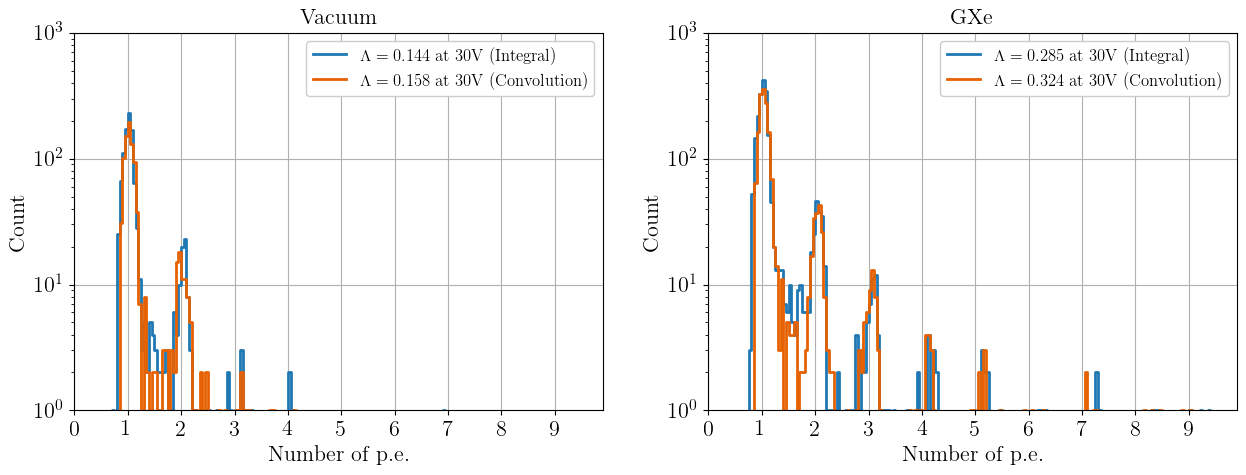

In [21]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Count')
plt.yscale('log')
plt.step(hx_vacuum_integral[:-1], h_vacuum_integral, lw=2, where='post', label='$\Lambda={:.3f}$ at 30V (Integral)'.format(ca_vacuum_integral))
plt.step(hx_vacuum[:-1], h_vacuum, lw=2, where='post', label='$\Lambda={:.3f}$ at 30V (Convolution)'.format(ca_vacuum))
plt.legend(loc='upper right')
plt.title('Vacuum')

plt.subplot(1,2,2)
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Count')
plt.yscale('log')
plt.step(hx_GXe_integral[:-1], h_GXe_integral, lw=2, where='post', label='$\Lambda={:.3f}$ at 30V (Integral)'.format(ca_GXe_integral))
plt.step(hx_GXe[:-1], h_GXe, lw=2, where='post', label='$\Lambda={:.3f}$ at 30V (Convolution)'.format(ca_GXe))
plt.legend(loc='upper right')
plt.title('GXe')
plt.savefig('30_V_Comparison.pdf')
plt.show()

In [22]:
print(gain_err_list_vacuum)
print(gain_err_list_GXe)
print(integral_err_list_vacuum)
print(integral_err_list_GXe)

[0.10881490704299134]
[0.05636275162582166]
[1.182627508927002]
[0.936429989050465]


In [23]:
data_vacuum = SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/', 
                    Selection='*DCR_31V*.h5')
data_vacuum.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

for i,File in enumerate(natsorted(data_vacuum.Files)):

    print(i,File)
#     print('Getting data...')
    data_vacuum.ImportDataFromHDF5(File, data_vacuum.Ch)
    
    
data_GXe = SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211201/', 
                    Selection='*DCR_31V_overnight*.h5')
data_GXe.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

for i,File in enumerate(natsorted(data_GXe.Files)[:20]):

    print(i,File)
#     print('Getting data...')
    data_GXe.ImportDataFromHDF5(File, data_GXe.Ch)
    

    
vacuum_freq=1/(100e-3*100*len(natsorted(data_vacuum.Files)))
GXe_freq=1/(100e-3*100*len(natsorted(data_GXe.Files)[:20]))

0 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_31V_0.h5
1 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_31V_1.h5
2 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_31V_2.h5
3 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_31V_3.h5
4 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_31V_4.h5
5 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_31V_5.h5
6 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_31V_6.h5
7 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_31V_7.h5
8 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_31V_8.h5
9 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_31V_9.h5
10 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_31V_10.h5
11 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203

In [24]:
data=data_vacuum.Ch[0].Amp
time=data_vacuum.Ch[0].Time
scale=data_vacuum.Ch[0].TScale
order=3
lowfreq=100
highfreq=100000
band_type='band'
sampling_time=data_vacuum.Ch[0].Time[1]-data_vacuum.Ch[0].Time[0]
mode='same'
Height=28
Distance=1

In [25]:
peak_heights_vacuum=peak_finding(Height,Distance)

peak_integral_vacuum=peak_integral(Height,Distance)

h_vacuum,hx_vacuum = np.histogram(peak_heights_vacuum, bins=np.arange(0,300,1))

h_vacuum_integral,hx_vacuum_integral = np.histogram(peak_integral_vacuum, bins=np.linspace(0,2000,200))


pe_vacuum = np.median(peak_heights_vacuum)

median_integral_vacuum=np.median(peak_integral_vacuum)




In [26]:
data=data_GXe.Ch[0].Amp
time=data_GXe.Ch[0].Time
scale=data_GXe.Ch[0].TScale
order=3
lowfreq=100
highfreq=100000
band_type='band'
sampling_time=data_GXe.Ch[0].Time[1]-data_GXe.Ch[0].Time[0]
mode='same'
Height=28
Distance=1

In [27]:
peak_heights_GXe=peak_finding(Height,Distance)

h_GXe,hx_GXe = np.histogram(peak_heights_GXe, bins=np.arange(0,300,1))
pe_GXe = np.median(peak_heights_GXe)


peak_integral_GXe=peak_integral(Height,Distance)

h_GXe_integral,hx_GXe_integral = np.histogram(peak_integral_GXe, bins=np.linspace(0,2000,200))

median_integral_GXe=np.median(peak_integral_GXe)



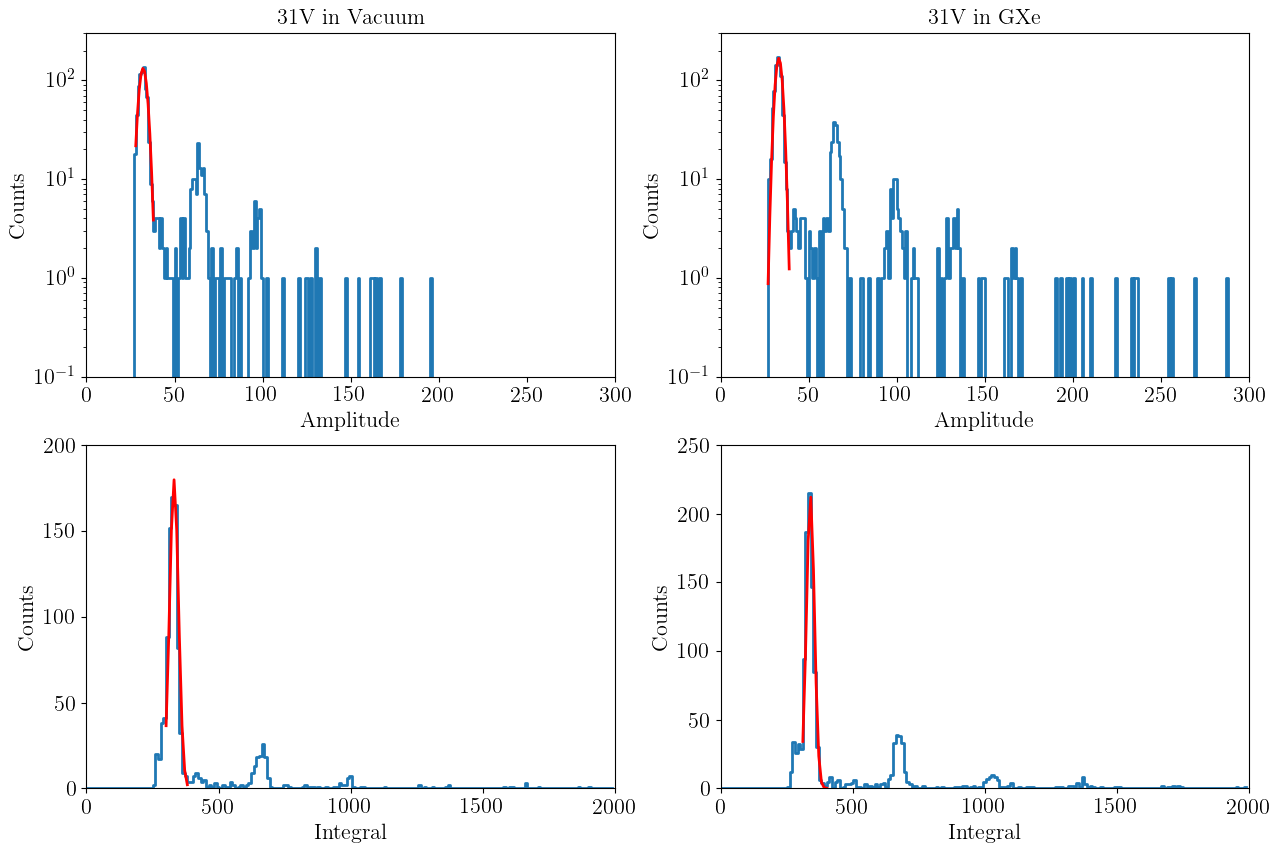

In [30]:
def gauss_func(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))



plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
for i in range(1,2):
    cut_vacuum = np.where((hx_vacuum[:-1]>pe_vacuum*i-6) & (hx_vacuum[:-1]<pe_vacuum*i+(5/i)))
    
    popt_vacuum,pcov_vacuum = curve_fit(gauss_func, hx_vacuum[:-1][cut_vacuum], h_vacuum[cut_vacuum], 
                          p0=[np.max(h_vacuum[cut_vacuum]), pe_vacuum*i,10],maxfev=100000)

    plt.plot(hx_vacuum[:-1][cut_vacuum], gauss_func(hx_vacuum[:-1][cut_vacuum], *popt_vacuum), color='r', zorder=10)
    plt.step(hx_vacuum[:-1], h_vacuum, lw=2)
    plt.xlabel('Amplitude')
    plt.ylabel('Counts')
    plt.yscale('log')
    plt.ylim(0.1,300)
    plt.title('31V in Vacuum')
plt.subplot(2,2,2)
for i in range(1,2):
    cut_GXe = np.where((hx_GXe[:-1]>pe_GXe*i-8) & (hx_GXe[:-1]<pe_GXe*i+(5/i)))
    
    popt_GXe,pcov_GXe = curve_fit(gauss_func, hx_GXe[:-1][cut_GXe], h_GXe[cut_GXe], 
                          p0=[np.max(h_GXe[cut_GXe]), pe_GXe*i,10],maxfev=100000)

    plt.plot(hx_GXe[:-1][cut_GXe], gauss_func(hx_GXe[:-1][cut_GXe], *popt_GXe), color='r', zorder=10)
    plt.step(hx_GXe[:-1], h_GXe, lw=2)
    plt.xlabel('Amplitude')
    plt.ylabel('Counts')
    plt.yscale('log')
    plt.ylim(0.1,300)
    plt.title('31V in GXe')

plt.subplot(2,2,3)

BINS=np.linspace(0,1000,100)
cut_vacuum_integral=np.where((hx_vacuum_integral[:-1]<median_integral_vacuum+50) & (hx_vacuum_integral[:-1]>median_integral_vacuum-50))
# plt.hist(peak_integral_10,bins=BINS,lw=2=1,histtype='step',label='-1 $\mu$s to 10 $\mu$s')
popt_vacuum_integral,pcov_vacuum_integral=curve_fit(gauss_func,hx_vacuum_integral[:-1][:-1][cut_vacuum_integral],h_vacuum_integral[:-1][cut_vacuum_integral],p0=[np.max(h_vacuum_integral[:-1][cut_vacuum_integral]),median_integral_vacuum,10],maxfev=100000)
plt.plot(hx_vacuum_integral[:-1][cut_vacuum_integral],gauss_func(hx_vacuum_integral[:-1][cut_vacuum_integral],*popt_vacuum_integral),color='r', zorder=10)
plt.step(hx_vacuum_integral[:-1], h_vacuum_integral, lw=2)
plt.xlabel('Integral')
plt.ylabel('Counts')




plt.subplot(2,2,4)

cut_GXe_integral=np.where((hx_GXe_integral[:-1]<median_integral_GXe+50) & (hx_GXe_integral[:-1]>median_integral_GXe-50))
# plt.hist(peak_integral_10,bins=BINS,lw=2=1,histtype='step',label='-1 $\mu$s to 10 $\mu$s')
popt_GXe_integral,pcov_GXe_integral=curve_fit(gauss_func,hx_GXe_integral[:-1][:-1][cut_GXe_integral],h_GXe_integral[:-1][cut_GXe_integral],p0=[np.max(h_GXe_integral[:-1][cut_GXe_integral]),median_integral_GXe,10],maxfev=100000)
plt.plot(hx_GXe_integral[:-1][cut_GXe_integral],gauss_func(hx_GXe_integral[:-1][cut_GXe_integral],*popt_GXe_integral),color='r', zorder=10)
plt.step(hx_GXe_integral[:-1], h_GXe_integral, lw=2)
plt.xlabel('Integral')
plt.ylabel('Counts')




plt.show()




gain_vacuum=popt_vacuum[1]
gain_list_vacuum.append(gain_vacuum)
gain_err_vacuum=np.sqrt(np.diag(pcov_vacuum))
gain_err_list_vacuum.append(gain_err_vacuum[1])

gain_GXe=popt_GXe[1]
gain_list_GXe.append(gain_GXe)
gain_err_GXe=np.sqrt(np.diag(pcov_GXe))
gain_err_list_GXe.append(gain_err_GXe[1])



first_integral_vacuum=popt_vacuum_integral[1]
integral_list_vacuum.append(first_integral_vacuum)
integral_err_vacuum=np.sqrt(np.diag(pcov_vacuum_integral))
integral_err_list_vacuum.append(integral_err_vacuum[1])
  

first_integral_GXe=popt_GXe_integral[1]
integral_list_GXe.append(first_integral_GXe)
integral_err_GXe=np.sqrt(np.diag(pcov_GXe_integral))
integral_err_list_GXe.append(integral_err_GXe[1])


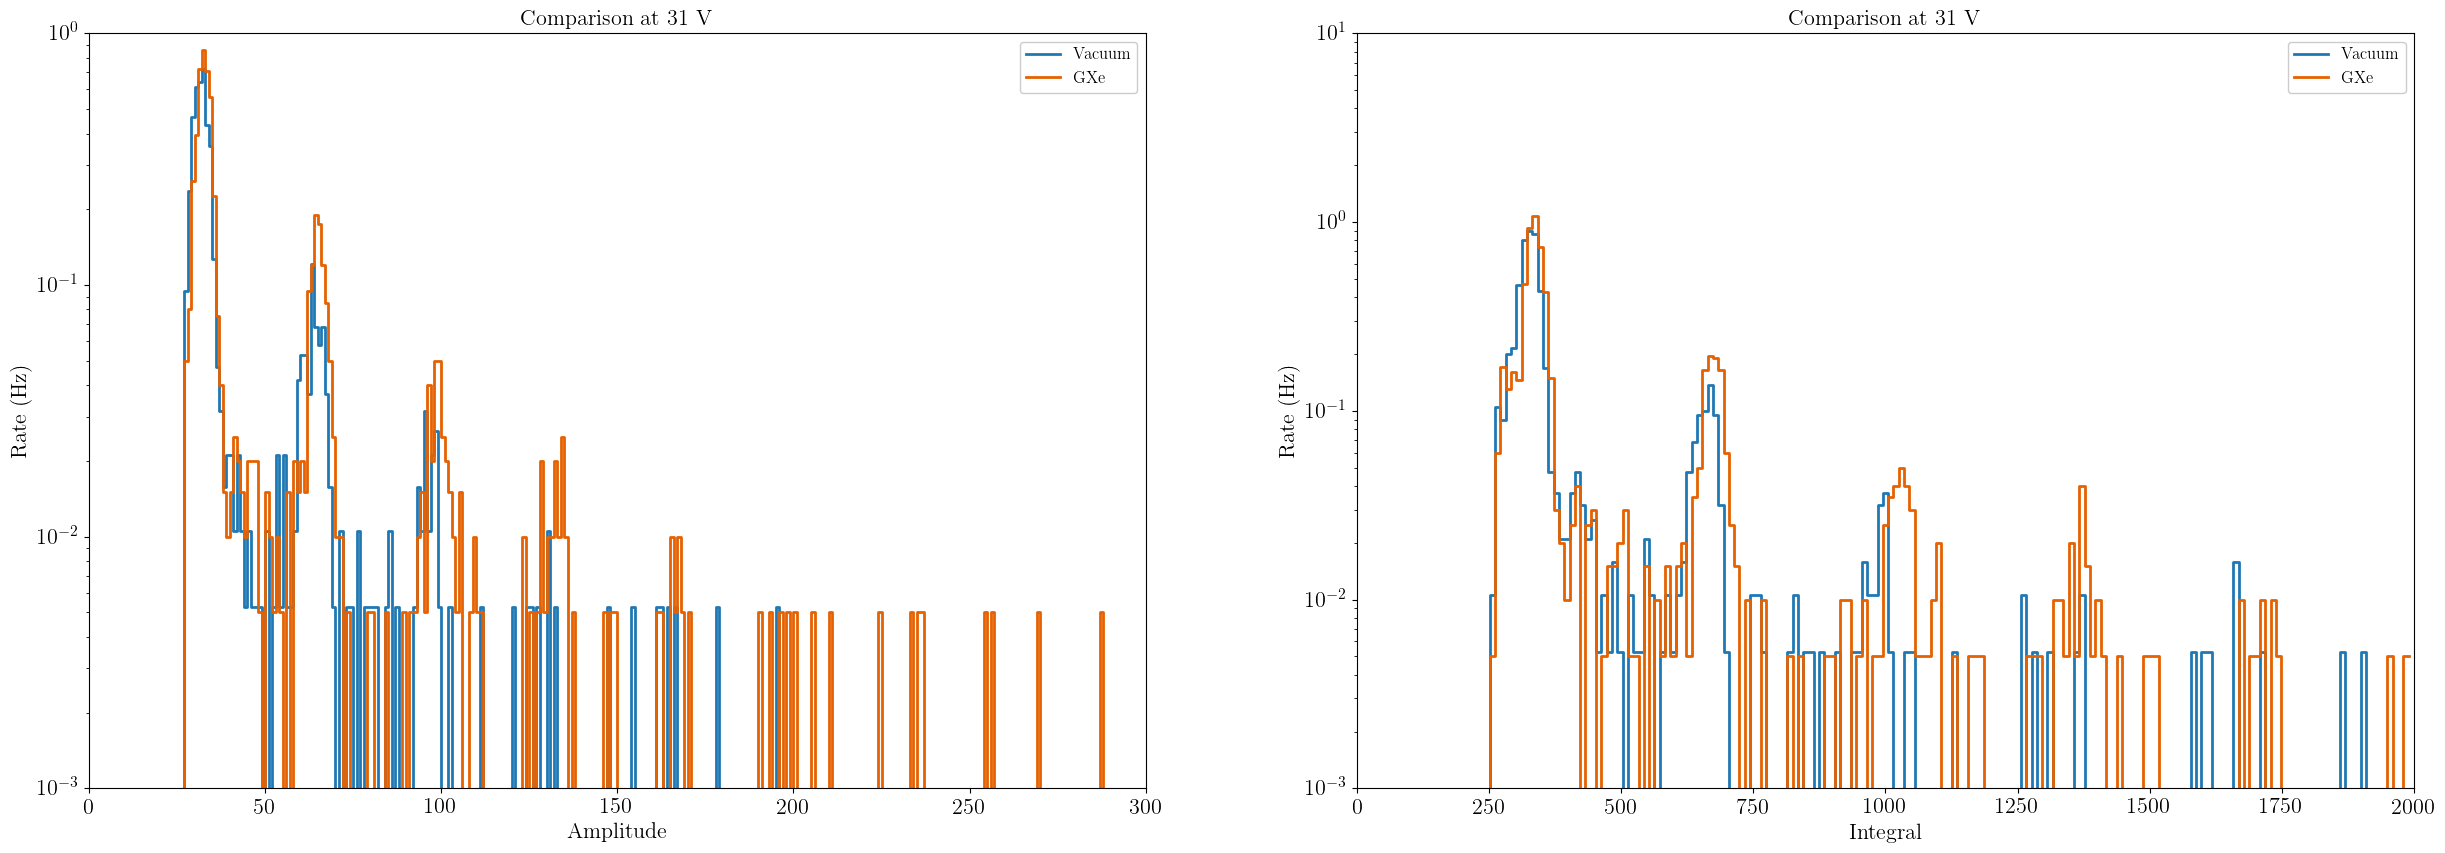

In [31]:
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.step(hx_vacuum[:-1], h_vacuum*vacuum_freq, lw=2,label='Vacuum')
plt.step(hx_GXe[:-1], h_GXe*GXe_freq, lw=2,label='GXe')
plt.xlabel('Amplitude')
plt.ylabel('Rate (Hz)')
plt.yscale('log')
# plt.ylim(0.1,300)
plt.title('Comparison at 31 V')
plt.legend(loc=1)


plt.subplot(1,2,2)
plt.step(hx_vacuum_integral[:-1], h_vacuum_integral*vacuum_freq, lw=2,label='Vacuum')
plt.step(hx_GXe_integral[:-1], h_GXe_integral*GXe_freq, lw=2,label='GXe')
plt.xlabel('Integral')
plt.ylabel('Rate (Hz)')
plt.title('Comparison at 31 V')
plt.legend(loc=1)
plt.yscale('log')

plt.show()

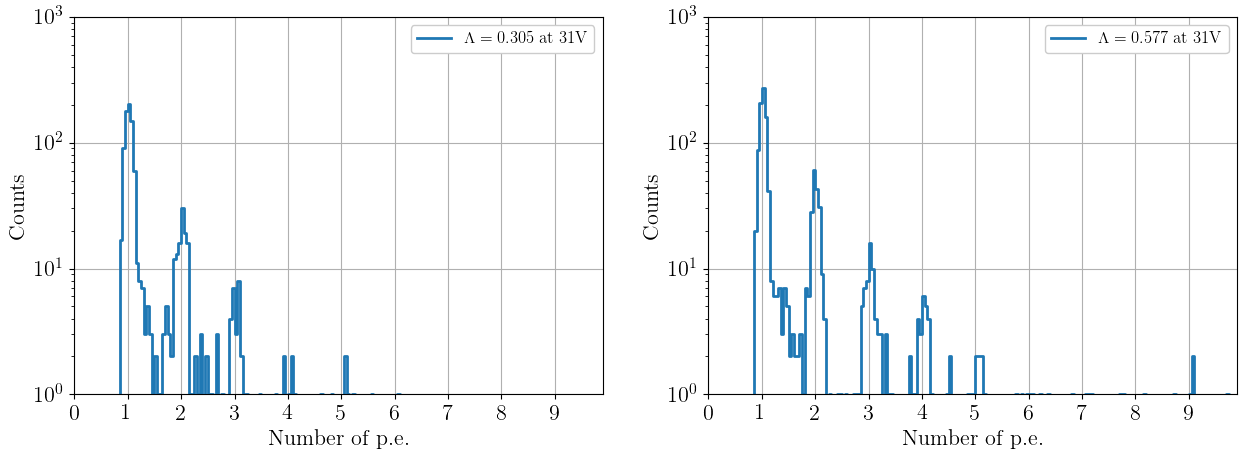

In [32]:
peak_height_calib_vacuum = np.array(peak_heights_vacuum)/np.mean(gain_vacuum)
ca_vacuum = (np.mean(peak_height_calib_vacuum) - 1)
ca_list_vacuum.append(ca_vacuum)
Yale_ca_RMS_vacuum.append(np.sqrt(np.mean(np.square(peak_height_calib_vacuum)))-1)
Yale_ca_err_vacuum.append(np.std(peak_height_calib_vacuum)/np.sqrt(len(peak_height_calib_vacuum)))


peak_height_calib_GXe = np.array(peak_heights_GXe)/np.mean(gain_GXe)
ca_GXe = (np.mean(peak_height_calib_GXe) - 1)
ca_list_GXe.append(ca_GXe)
Yale_ca_RMS_GXe.append(np.sqrt(np.mean(np.square(peak_height_calib_GXe)))-1)
Yale_ca_err_GXe.append(np.std(peak_height_calib_GXe)/np.sqrt(len(peak_height_calib_GXe)))


h_vacuum,hx_vacuum = np.histogram(peak_height_calib_vacuum, bins=np.arange(0,10,0.05))

h_GXe,hx_GXe = np.histogram(peak_height_calib_GXe, bins=np.arange(0,10,0.05))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx_vacuum[:-1], h_vacuum, lw=2, where='post', label='$\Lambda={:.3f}$ at 31V'.format(ca_vacuum))
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx_GXe[:-1], h_GXe, lw=2, where='post', label='$\Lambda={:.3f}$ at 31V'.format(ca_GXe))
plt.legend(loc='upper right')

plt.show()


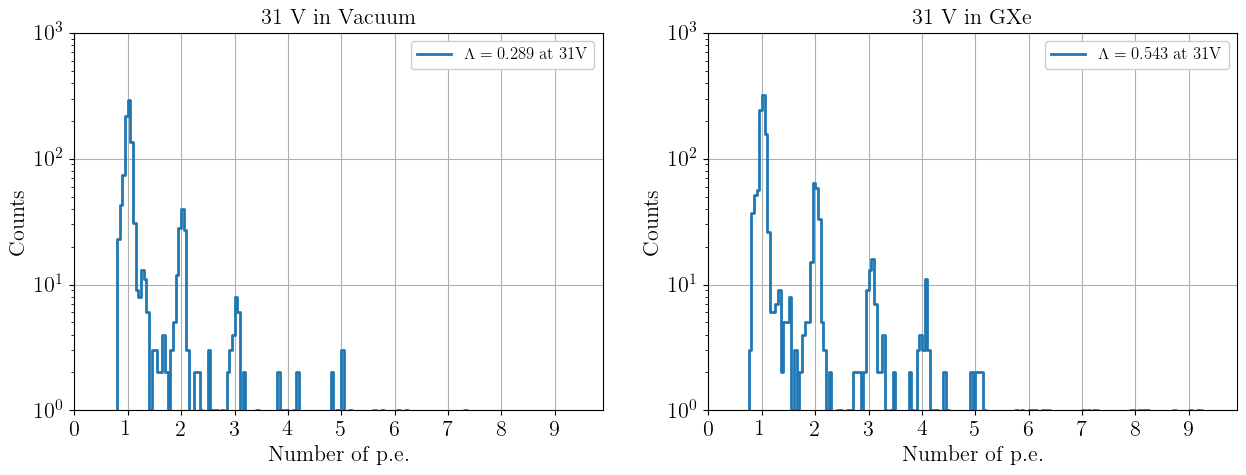

In [33]:
peak_integral_calib_vacuum = np.array(peak_integral_vacuum)/(first_integral_vacuum)
ca_vacuum_integral = (np.mean(peak_integral_calib_vacuum) - 1)
ca_list_vacuum_integral.append(ca_vacuum_integral)
Yale_ca_RMS_vacuum_integral.append(np.sqrt(np.mean(np.square(peak_integral_calib_vacuum)))-1)
Yale_ca_err_vacuum_integral.append(np.std(peak_integral_calib_vacuum)/np.sqrt(len(peak_integral_calib_vacuum)))


peak_integral_calib_GXe = np.array(peak_integral_GXe)/(first_integral_GXe)
ca_GXe_integral = (np.mean(peak_integral_calib_GXe) - 1)
ca_list_GXe_integral.append(ca_GXe_integral)
Yale_ca_RMS_GXe_integral.append(np.sqrt(np.mean(np.square(peak_integral_calib_GXe)))-1)
Yale_ca_err_GXe_integral.append(np.std(peak_integral_calib_GXe)/np.sqrt(len(peak_integral_calib_GXe)))


h_vacuum_integral,hx_vacuum_integral = np.histogram(peak_integral_calib_vacuum, bins=np.arange(0,10,0.05))

h_GXe_integral,hx_GXe_integral = np.histogram(peak_integral_calib_GXe, bins=np.arange(0,10,0.05))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx_vacuum_integral[:-1], h_vacuum_integral, lw=2, where='post', label='$\Lambda={:.3f}$ at 31V'.format(ca_vacuum_integral))
plt.legend(loc='upper right')
plt.title('31 V in Vacuum')
plt.subplot(1,2,2)
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx_GXe_integral[:-1], h_GXe_integral, lw=2, where='post', label='$\Lambda={:.3f}$ at 31V'.format(ca_GXe_integral))
plt.legend(loc='upper right')
plt.title('31 V in GXe')
plt.show()


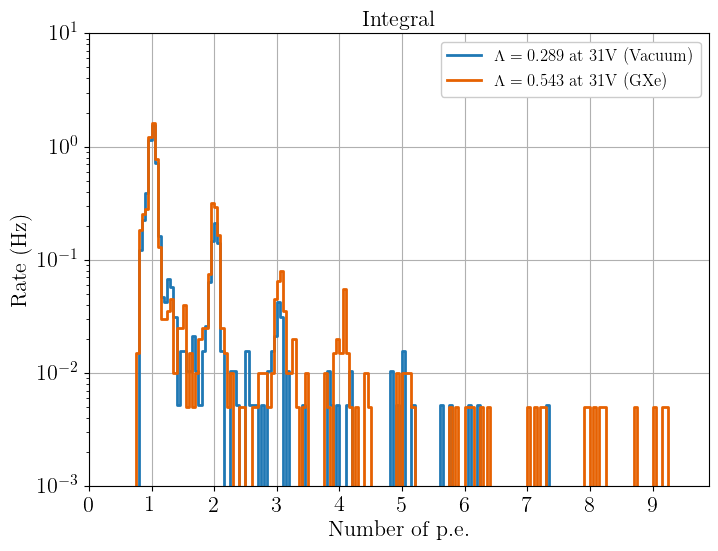

In [34]:
plt.figure(figsize=(8,6))
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Rate (Hz)')
plt.yscale('log')
plt.title('Integral')
plt.step(hx_vacuum_integral[:-1], h_vacuum_integral*vacuum_freq, lw=2, where='post', label='$\Lambda={:.3f}$ at 31V (Vacuum)'.format(ca_vacuum_integral))
plt.step(hx_GXe_integral[:-1], h_GXe_integral*GXe_freq, lw=2, where='post', label='$\Lambda={:.3f}$ at 31V (GXe)'.format(ca_GXe_integral))
plt.legend(loc='upper right')
plt.show()

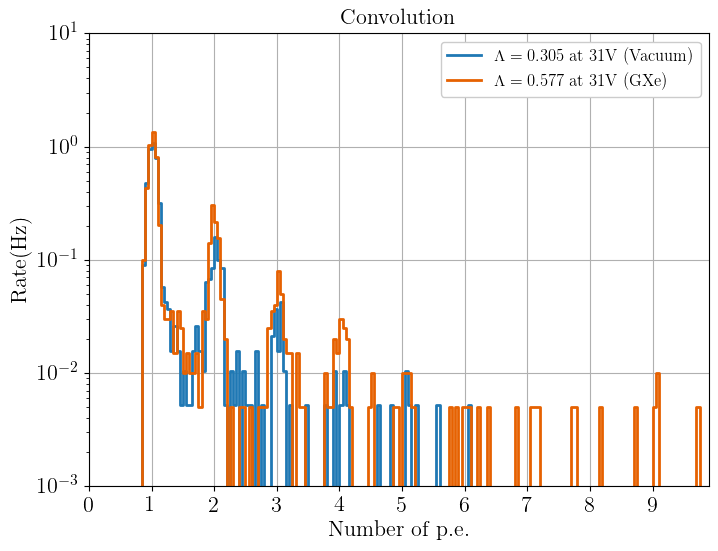

In [35]:
plt.figure(figsize=(8,6))
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Rate(Hz)')
plt.yscale('log')
plt.step(hx_vacuum[:-1], h_vacuum*vacuum_freq, lw=2, where='post', label='$\Lambda={:.3f}$ at 31V (Vacuum)'.format(ca_vacuum))
plt.step(hx_GXe[:-1], h_GXe*GXe_freq, lw=2, where='post', label='$\Lambda={:.3f}$ at 31V (GXe)'.format(ca_GXe))
plt.legend(loc='upper right')
plt.title('Convolution')
plt.show()

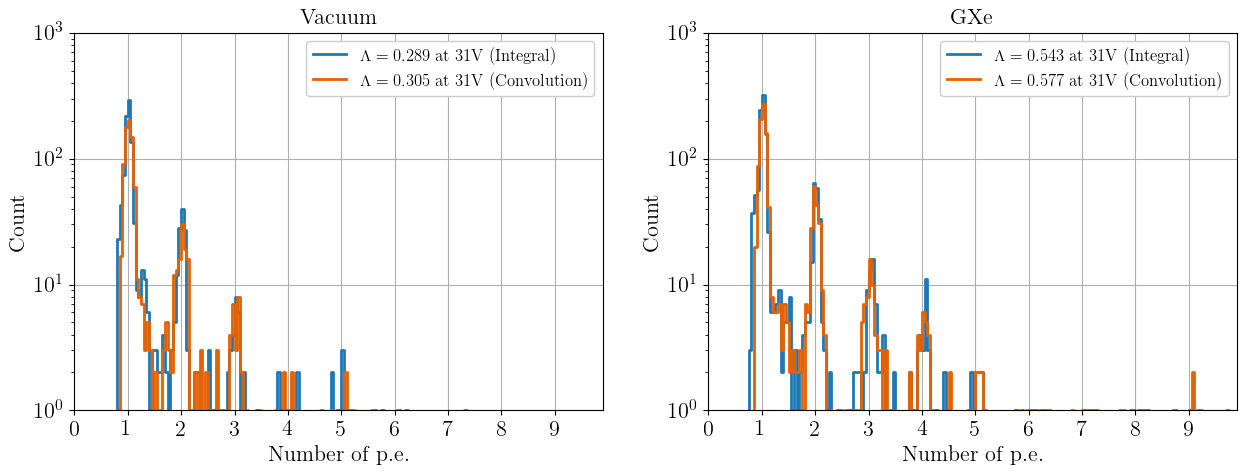

In [36]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Count')
plt.yscale('log')
plt.step(hx_vacuum_integral[:-1], h_vacuum_integral, lw=2, where='post', label='$\Lambda={:.3f}$ at 31V (Integral)'.format(ca_vacuum_integral))
plt.step(hx_vacuum[:-1], h_vacuum, lw=2, where='post', label='$\Lambda={:.3f}$ at 31V (Convolution)'.format(ca_vacuum))
plt.legend(loc='upper right')
plt.title('Vacuum')

plt.subplot(1,2,2)
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Count')
plt.yscale('log')
plt.step(hx_GXe_integral[:-1], h_GXe_integral, lw=2, where='post', label='$\Lambda={:.3f}$ at 31V (Integral)'.format(ca_GXe_integral))
plt.step(hx_GXe[:-1], h_GXe, lw=2, where='post', label='$\Lambda={:.3f}$ at 31V (Convolution)'.format(ca_GXe))
plt.legend(loc='upper right')
plt.title('GXe')

plt.show()

In [37]:
data_vacuum = SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/', 
                    Selection='*DCR_32V*.h5')
data_vacuum.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

for i,File in enumerate(natsorted(data_vacuum.Files)):

    print(i,File)
#     print('Getting data...')
    data_vacuum.ImportDataFromHDF5(File, data_vacuum.Ch)
    
    
data_GXe = SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211201/', 
                    Selection='*DCR_32V*.h5')
data_GXe.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

for i,File in enumerate(natsorted(data_GXe.Files)):

    print(i,File)
#     print('Getting data...')
    data_GXe.ImportDataFromHDF5(File, data_GXe.Ch)
    
    
vacuum_freq=1/(100e-3*100*len(natsorted(data_vacuum.Files)))
GXe_freq=1/(100e-3*100*len(natsorted(data_GXe.Files)))

0 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_32V_0.h5
1 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_32V_1.h5
2 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_32V_2.h5
3 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_32V_3.h5
4 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_32V_4.h5
5 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_32V_5.h5
6 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_32V_6.h5
7 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_32V_7.h5
8 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_32V_8.h5
9 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_32V_9.h5
10 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_32V_10.h5
11 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203

In [38]:
data=data_vacuum.Ch[0].Amp
time=data_vacuum.Ch[0].Time
scale=data_vacuum.Ch[0].TScale
order=3
lowfreq=100
highfreq=100000
band_type='band'
sampling_time=data_vacuum.Ch[0].Time[1]-data_vacuum.Ch[0].Time[0]
mode='same'
Height=35
Distance=1

In [39]:
peak_heights_vacuum=peak_finding(Height,Distance)

peak_integral_vacuum=peak_integral(Height,Distance)

h_vacuum,hx_vacuum = np.histogram(peak_heights_vacuum, bins=np.arange(0,300,1))

h_vacuum_integral,hx_vacuum_integral = np.histogram(peak_integral_vacuum, bins=np.linspace(0,2500,250))


pe_vacuum = np.median(peak_heights_vacuum)

median_integral_vacuum=np.median(peak_integral_vacuum)




In [40]:
data=data_GXe.Ch[0].Amp
time=data_GXe.Ch[0].Time
scale=data_GXe.Ch[0].TScale
order=3
lowfreq=100
highfreq=100000
band_type='band'
sampling_time=data_GXe.Ch[0].Time[1]-data_GXe.Ch[0].Time[0]
mode='same'
Height=35
Distance=1

In [41]:
peak_heights_GXe=peak_finding(Height,Distance)

h_GXe,hx_GXe = np.histogram(peak_heights_GXe, bins=np.arange(0,300,1))
pe_GXe = np.median(peak_heights_GXe)


peak_integral_GXe=peak_integral(Height,Distance)

h_GXe_integral,hx_GXe_integral = np.histogram(peak_integral_GXe, bins=np.linspace(0,2500,250))

median_integral_GXe=np.median(peak_integral_GXe)


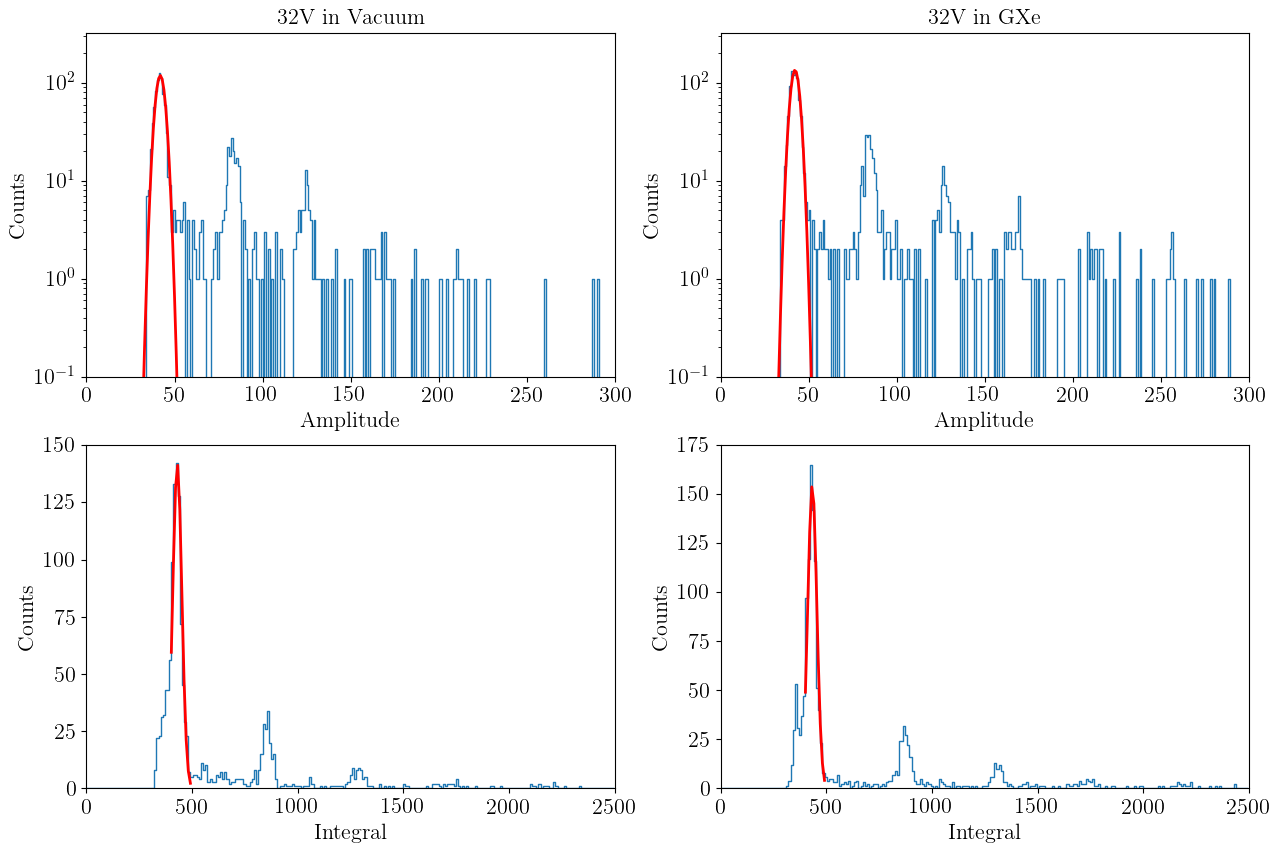

In [42]:
def gauss_func(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))



plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
for i in range(1,2):
    cut_vacuum = np.where((hx_vacuum[:-1]>pe_vacuum*i-20) & (hx_vacuum[:-1]<pe_vacuum*i+20))
    
    popt_vacuum,pcov_vacuum = curve_fit(gauss_func, hx_vacuum[:-1][cut_vacuum], h_vacuum[cut_vacuum], 
                          p0=[np.max(h_vacuum[cut_vacuum]), pe_vacuum*i,10],maxfev=100000)

    plt.plot(hx_vacuum[:-1][cut_vacuum], gauss_func(hx_vacuum[:-1][cut_vacuum], *popt_vacuum), color='r', zorder=10)
    plt.step(hx_vacuum[:-1], h_vacuum, lw=1)
    plt.xlabel('Amplitude')
    plt.ylabel('Counts')
    plt.yscale('log')
    plt.ylim(0.1,320)
    plt.title('32V in Vacuum')
plt.subplot(2,2,2)
for i in range(1,2):
    cut_GXe = np.where((hx_GXe[:-1]>pe_GXe*i-20) & (hx_GXe[:-1]<pe_GXe*i+20))
    
    popt_GXe,pcov_GXe = curve_fit(gauss_func, hx_GXe[:-1][cut_GXe], h_GXe[cut_GXe], 
                          p0=[np.max(h_GXe[cut_GXe]), pe_GXe*i,10],maxfev=100000)

    plt.plot(hx_GXe[:-1][cut_GXe], gauss_func(hx_GXe[:-1][cut_GXe], *popt_GXe), color='r', zorder=10)
    plt.step(hx_GXe[:-1], h_GXe, lw=1)
    plt.xlabel('Amplitude')
    plt.ylabel('Counts')
    plt.yscale('log')
    plt.ylim(0.1,320)
    plt.title('32V in GXe')

plt.subplot(2,2,3)

BINS=np.linspace(0,1000,100)
cut_vacuum_integral=np.where((hx_vacuum_integral[:-1]<median_integral_vacuum+50) & (hx_vacuum_integral[:-1]>median_integral_vacuum-50))
# plt.hist(peak_integral_10,bins=BINS,lw=1,histtype='step',label='-1 $\mu$s to 10 $\mu$s')
popt_vacuum_integral,pcov_vacuum_integral=curve_fit(gauss_func,hx_vacuum_integral[:-1][:-1][cut_vacuum_integral],h_vacuum_integral[:-1][cut_vacuum_integral],p0=[np.max(h_vacuum_integral[:-1][cut_vacuum_integral]),median_integral_vacuum,10],maxfev=100000)
plt.plot(hx_vacuum_integral[:-1][cut_vacuum_integral],gauss_func(hx_vacuum_integral[:-1][cut_vacuum_integral],*popt_vacuum_integral),color='r', zorder=10)
plt.step(hx_vacuum_integral[:-1], h_vacuum_integral, lw=1)
plt.xlabel('Integral')
plt.ylabel('Counts')




plt.subplot(2,2,4)

cut_GXe_integral=np.where((hx_GXe_integral[:-1]<median_integral_GXe+50) & (hx_GXe_integral[:-1]>median_integral_GXe-50))
# plt.hist(peak_integral_10,bins=BINS,lw=1,histtype='step',label='-1 $\mu$s to 10 $\mu$s')
popt_GXe_integral,pcov_GXe_integral=curve_fit(gauss_func,hx_GXe_integral[:-1][:-1][cut_GXe_integral],h_GXe_integral[:-1][cut_GXe_integral],p0=[np.max(h_GXe_integral[:-1][cut_GXe_integral]),median_integral_GXe,10],maxfev=100000)
plt.plot(hx_GXe_integral[:-1][cut_GXe_integral],gauss_func(hx_GXe_integral[:-1][cut_GXe_integral],*popt_GXe_integral),color='r', zorder=10)
plt.step(hx_GXe_integral[:-1], h_GXe_integral, lw=1)
plt.xlabel('Integral')
plt.ylabel('Counts')




plt.show()




gain_vacuum=popt_vacuum[1]
gain_list_vacuum.append(gain_vacuum)
gain_err_vacuum=np.sqrt(np.diag(pcov_vacuum))
gain_err_list_vacuum.append(gain_err_vacuum[1])

gain_GXe=popt_GXe[1]
gain_list_GXe.append(gain_GXe)
gain_err_GXe=np.sqrt(np.diag(pcov_GXe))
gain_err_list_GXe.append(gain_err_GXe[1])



first_integral_vacuum=popt_vacuum_integral[1]
integral_list_vacuum.append(first_integral_vacuum)
integral_err_vacuum=np.sqrt(np.diag(pcov_vacuum_integral))
integral_err_list_vacuum.append(integral_err_vacuum[1])
  

first_integral_GXe=popt_GXe_integral[1]
integral_list_GXe.append(first_integral_GXe)
integral_err_GXe=np.sqrt(np.diag(pcov_GXe_integral))
integral_err_list_GXe.append(integral_err_GXe[1])


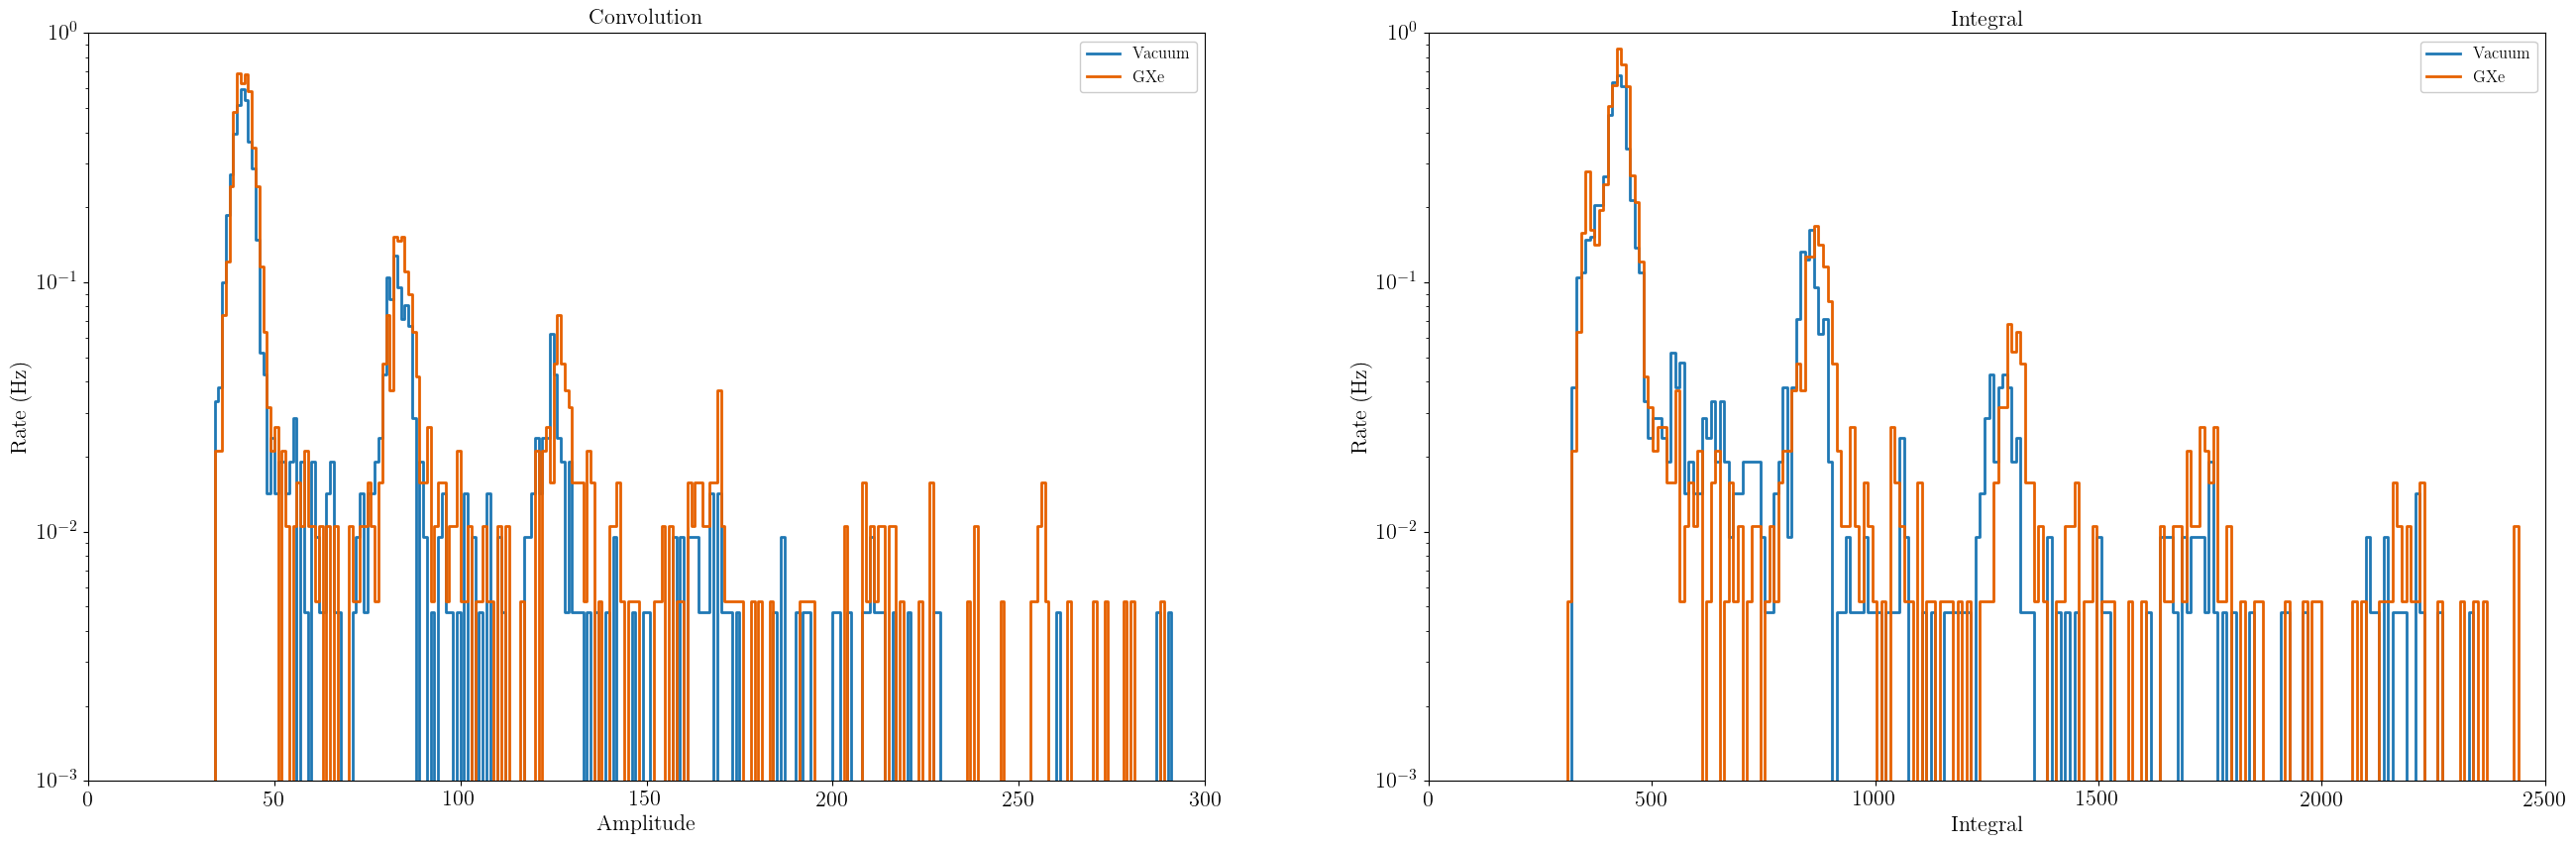

In [43]:
plt.figure(figsize=(32,10))
plt.subplot(1,2,1)
plt.step(hx_vacuum[:-1], h_vacuum*vacuum_freq, lw=2,label='Vacuum')
plt.step(hx_GXe[:-1], h_GXe*GXe_freq, lw=2,label='GXe')
plt.xlabel('Amplitude')
plt.ylabel('Rate (Hz)')
plt.yscale('log')
# plt.ylim(0.1,320)
plt.title('Convolution')
plt.legend(loc=1)


plt.subplot(1,2,2)
plt.step(hx_vacuum_integral[:-1], h_vacuum_integral*vacuum_freq, lw=2,label='Vacuum')
plt.step(hx_GXe_integral[:-1], h_GXe_integral*GXe_freq, lw=2,label='GXe')
plt.xlabel('Integral')
plt.ylabel('Rate (Hz)')
plt.title('Integral')
plt.yscale('log')
plt.legend(loc=1)

plt.show()

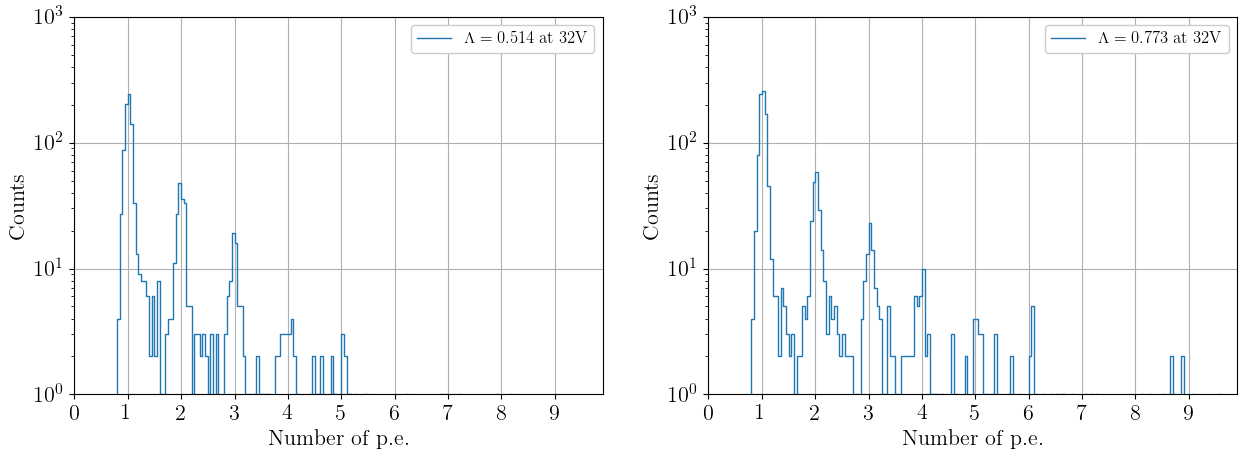

In [44]:
peak_height_calib_vacuum = np.array(peak_heights_vacuum)/np.mean(gain_vacuum)
ca_vacuum = (np.mean(peak_height_calib_vacuum) - 1)
ca_list_vacuum.append(ca_vacuum)
Yale_ca_RMS_vacuum.append(np.sqrt(np.mean(np.square(peak_height_calib_vacuum)))-1)
Yale_ca_err_vacuum.append(np.std(peak_height_calib_vacuum)/np.sqrt(len(peak_height_calib_vacuum)))


peak_height_calib_GXe = np.array(peak_heights_GXe)/np.mean(gain_GXe)
ca_GXe = (np.mean(peak_height_calib_GXe) - 1)
ca_list_GXe.append(ca_GXe)
Yale_ca_RMS_GXe.append(np.sqrt(np.mean(np.square(peak_height_calib_GXe)))-1)
Yale_ca_err_GXe.append(np.std(peak_height_calib_GXe)/np.sqrt(len(peak_height_calib_GXe)))


h_vacuum,hx_vacuum = np.histogram(peak_height_calib_vacuum, bins=np.arange(0,10,0.05))

h_GXe,hx_GXe = np.histogram(peak_height_calib_GXe, bins=np.arange(0,10,0.05))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx_vacuum[:-1], h_vacuum, lw=1, where='post', label='$\Lambda={:.3f}$ at 32V'.format(ca_vacuum))
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx_GXe[:-1], h_GXe, lw=1, where='post', label='$\Lambda={:.3f}$ at 32V'.format(ca_GXe))
plt.legend(loc='upper right')

plt.show()


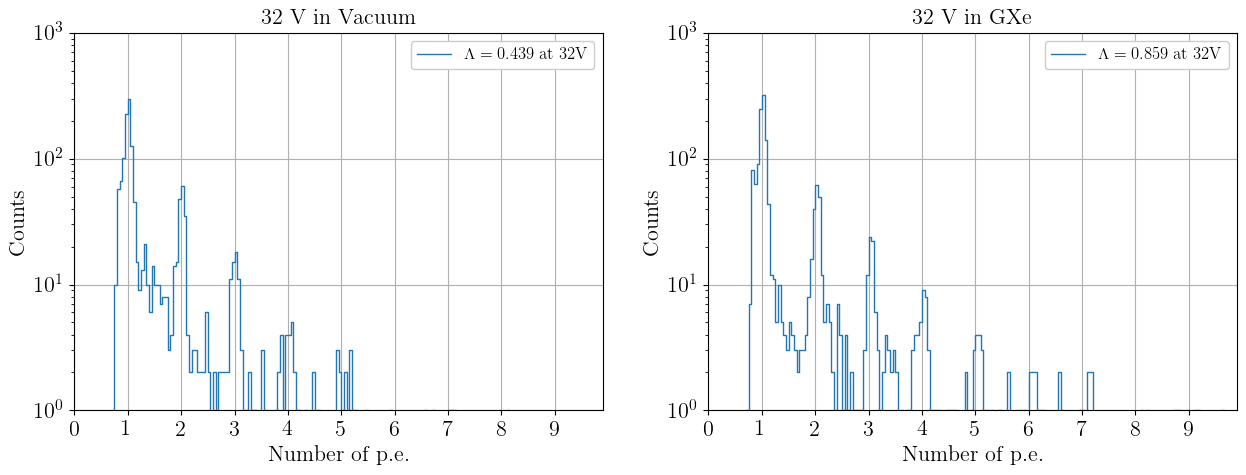

In [45]:
peak_integral_calib_vacuum = np.array(peak_integral_vacuum)/(first_integral_vacuum)
ca_vacuum_integral = (np.mean(peak_integral_calib_vacuum) - 1)
ca_list_vacuum_integral.append(ca_vacuum_integral)
Yale_ca_RMS_vacuum_integral.append(np.sqrt(np.mean(np.square(peak_integral_calib_vacuum)))-1)
Yale_ca_err_vacuum_integral.append(np.std(peak_integral_calib_vacuum)/np.sqrt(len(peak_integral_calib_vacuum)))


peak_integral_calib_GXe = np.array(peak_integral_GXe)/(first_integral_GXe)
ca_GXe_integral = (np.mean(peak_integral_calib_GXe) - 1)
ca_list_GXe_integral.append(ca_GXe_integral)
Yale_ca_RMS_GXe_integral.append(np.sqrt(np.mean(np.square(peak_integral_calib_GXe)))-1)
Yale_ca_err_GXe_integral.append(np.std(peak_integral_calib_GXe)/np.sqrt(len(peak_integral_calib_GXe)))


h_vacuum_integral,hx_vacuum_integral = np.histogram(peak_integral_calib_vacuum, bins=np.arange(0,10,0.05))

h_GXe_integral,hx_GXe_integral = np.histogram(peak_integral_calib_GXe, bins=np.arange(0,10,0.05))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx_vacuum_integral[:-1], h_vacuum_integral, lw=1, where='post', label='$\Lambda={:.3f}$ at 32V'.format(ca_vacuum_integral))
plt.legend(loc='upper right')
plt.title('32 V in Vacuum')
plt.subplot(1,2,2)
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx_GXe_integral[:-1], h_GXe_integral, lw=1, where='post', label='$\Lambda={:.3f}$ at 32V'.format(ca_GXe_integral))
plt.legend(loc='upper right')
plt.title('32 V in GXe')
plt.show()


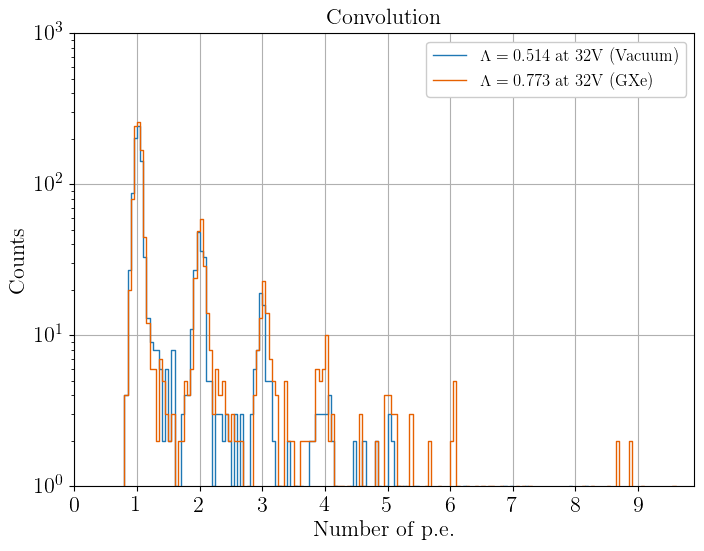

In [46]:
plt.figure(figsize=(8,6))
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx_vacuum[:-1], h_vacuum, lw=1, where='post', label='$\Lambda={:.3f}$ at 32V (Vacuum)'.format(ca_vacuum))
plt.step(hx_GXe[:-1], h_GXe, lw=1, where='post', label='$\Lambda={:.3f}$ at 32V (GXe)'.format(ca_GXe))
plt.legend(loc='upper right')
plt.title('Convolution')
plt.show()

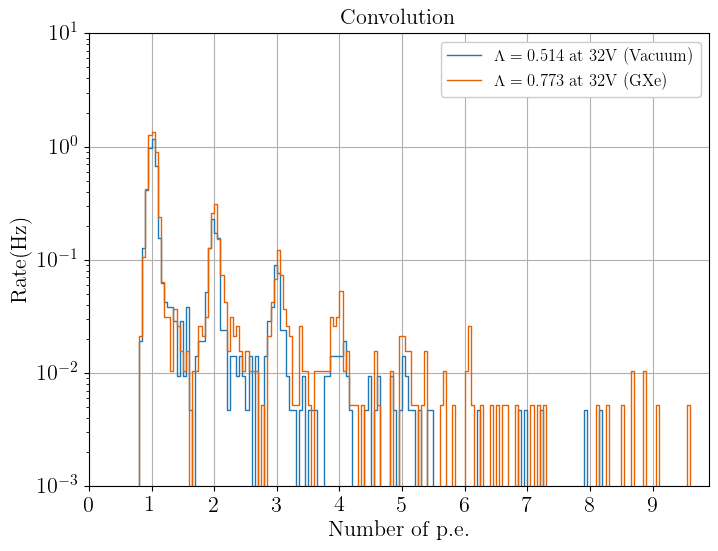

In [47]:
plt.figure(figsize=(8,6))
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Rate(Hz)')
plt.yscale('log')
plt.step(hx_vacuum[:-1], h_vacuum*vacuum_freq, lw=1, where='post', label='$\Lambda={:.3f}$ at 32V (Vacuum)'.format(ca_vacuum))
plt.step(hx_GXe[:-1], h_GXe*GXe_freq, lw=1, where='post', label='$\Lambda={:.3f}$ at 32V (GXe)'.format(ca_GXe))
plt.legend(loc='upper right')
plt.title('Convolution')
plt.show()

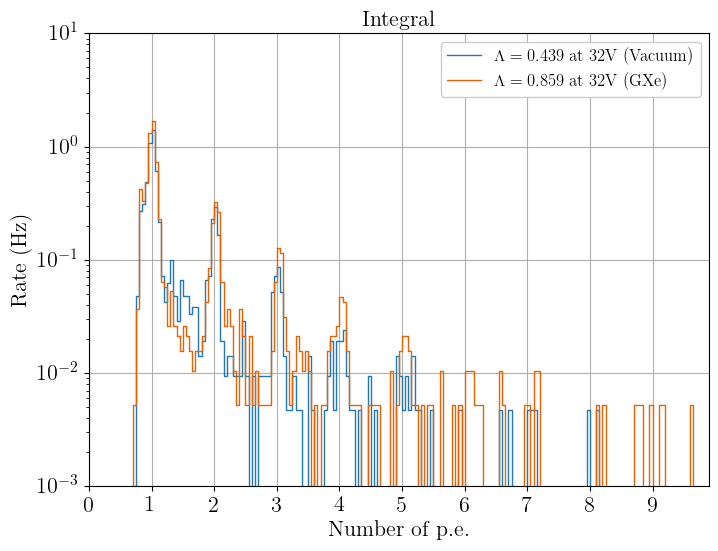

In [48]:
plt.figure(figsize=(8,6))
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Rate (Hz)')
plt.yscale('log')
plt.title('Integral')
plt.step(hx_vacuum_integral[:-1], h_vacuum_integral*vacuum_freq, lw=1, where='post', label='$\Lambda={:.3f}$ at 32V (Vacuum)'.format(ca_vacuum_integral))
plt.step(hx_GXe_integral[:-1], h_GXe_integral*GXe_freq, lw=1, where='post', label='$\Lambda={:.3f}$ at 32V (GXe)'.format(ca_GXe_integral))
plt.legend(loc='upper right')
plt.show()

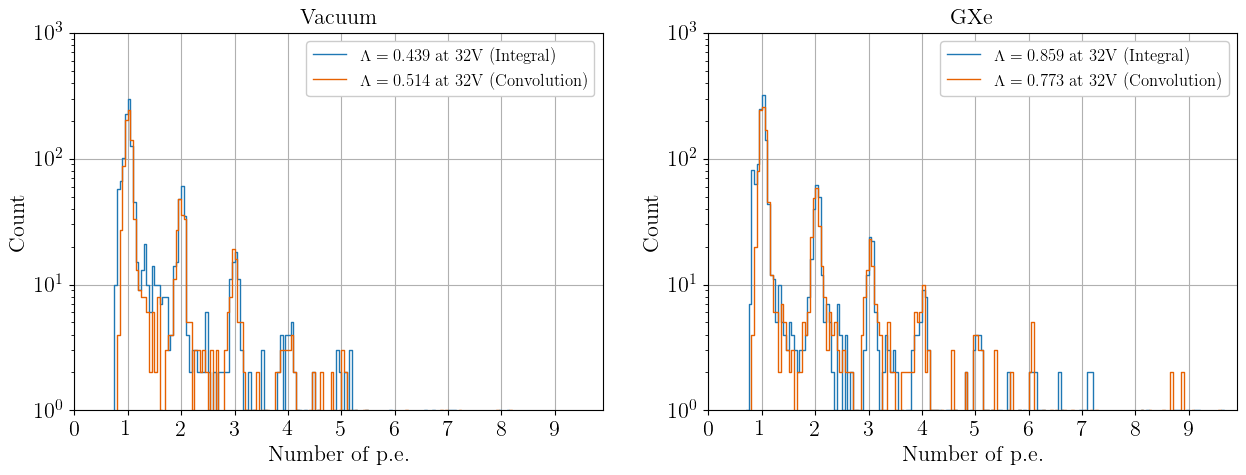

In [49]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Count')
plt.yscale('log')
plt.step(hx_vacuum_integral[:-1], h_vacuum_integral, lw=1, where='post', label='$\Lambda={:.3f}$ at 32V (Integral)'.format(ca_vacuum_integral))
plt.step(hx_vacuum[:-1], h_vacuum, lw=1, where='post', label='$\Lambda={:.3f}$ at 32V (Convolution)'.format(ca_vacuum))
plt.legend(loc='upper right')
plt.title('Vacuum')

plt.subplot(1,2,2)
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Count')
plt.yscale('log')
plt.step(hx_GXe_integral[:-1], h_GXe_integral, lw=1, where='post', label='$\Lambda={:.3f}$ at 32V (Integral)'.format(ca_GXe_integral))
plt.step(hx_GXe[:-1], h_GXe, lw=1, where='post', label='$\Lambda={:.3f}$ at 32V (Convolution)'.format(ca_GXe))
plt.legend(loc='upper right')
plt.title('GXe')

plt.show()

In [50]:
data_vacuum = SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/', 
                    Selection='*DCR_33V*.h5')
data_vacuum.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

for i,File in enumerate(natsorted(data_vacuum.Files)):

    print(i,File)
#     print('Getting data...')
    data_vacuum.ImportDataFromHDF5(File, data_vacuum.Ch)
    
    
data_GXe = SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211201/', 
                    Selection='*DCR_33V*.h5')
data_GXe.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

for i,File in enumerate(natsorted(data_GXe.Files)):

    print(i,File)
#     print('Getting data...')
    data_GXe.ImportDataFromHDF5(File, data_GXe.Ch)
    
    
vacuum_freq=1/(100e-3*100*len(natsorted(data_vacuum.Files)))
GXe_freq=1/(100e-3*100*len(natsorted(data_GXe.Files)))

0 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_33V_0.h5
1 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_33V_1.h5
2 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_33V_2.h5
3 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_33V_3.h5
4 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_33V_4.h5
5 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_33V_5.h5
6 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_33V_6.h5
7 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_33V_7.h5
8 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_33V_8.h5
9 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_33V_9.h5
10 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_33V_10.h5
11 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203

In [51]:
data=data_vacuum.Ch[0].Amp
time=data_vacuum.Ch[0].Time
scale=data_vacuum.Ch[0].TScale
order=3
lowfreq=100
highfreq=100000
band_type='band'
sampling_time=data_vacuum.Ch[0].Time[1]-data_vacuum.Ch[0].Time[0]
mode='same'
Height=42
Distance=1

In [52]:
peak_heights_vacuum=peak_finding(Height,Distance)

peak_integral_vacuum=peak_integral(Height,Distance)

h_vacuum,hx_vacuum = np.histogram(peak_heights_vacuum, bins=np.arange(0,300,1))

h_vacuum_integral,hx_vacuum_integral = np.histogram(peak_integral_vacuum, bins=np.linspace(0,3000,300))


pe_vacuum = np.median(peak_heights_vacuum)

median_integral_vacuum=np.median(peak_integral_vacuum)




In [53]:
data=data_GXe.Ch[0].Amp
time=data_GXe.Ch[0].Time
scale=data_GXe.Ch[0].TScale
order=3
lowfreq=100
highfreq=100000
band_type='band'
sampling_time=data_GXe.Ch[0].Time[1]-data_GXe.Ch[0].Time[0]
mode='same'
Height=42
Distance=1

In [54]:
peak_heights_GXe=peak_finding(Height,Distance)

h_GXe,hx_GXe = np.histogram(peak_heights_GXe, bins=np.arange(0,300,1))
pe_GXe = np.median(peak_heights_GXe)


peak_integral_GXe=peak_integral(Height,Distance)

h_GXe_integral,hx_GXe_integral = np.histogram(peak_integral_GXe, bins=np.linspace(0,3000,300))

median_integral_GXe=np.median(peak_integral_GXe)



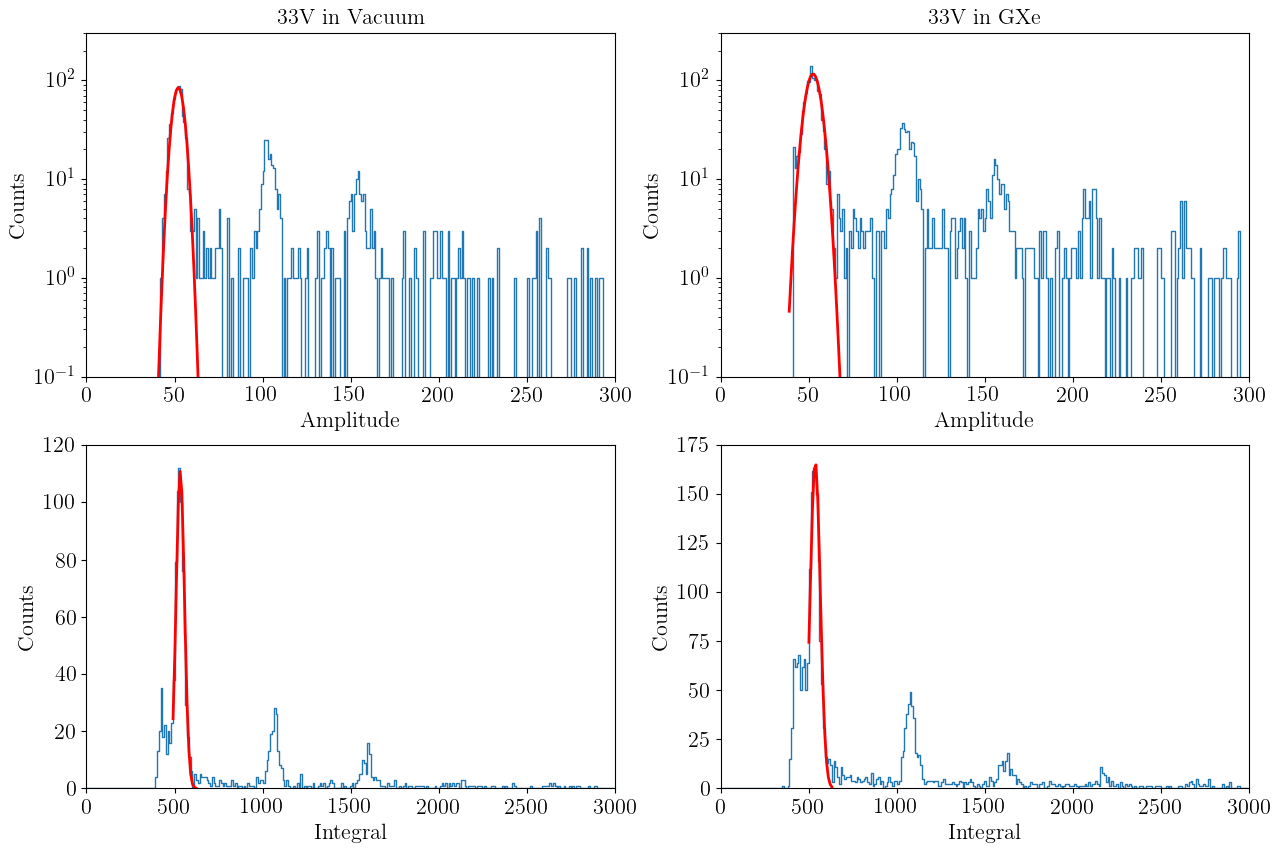

In [55]:
def gauss_func(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))



plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
for i in range(1,2):
    cut_vacuum = np.where((hx_vacuum[:-1]>pe_vacuum*i-20) & (hx_vacuum[:-1]<pe_vacuum*i+(10)))
    
    popt_vacuum,pcov_vacuum = curve_fit(gauss_func, hx_vacuum[:-1][cut_vacuum], h_vacuum[cut_vacuum], 
                          p0=[np.max(h_vacuum[cut_vacuum]), pe_vacuum*i,10],maxfev=100000)

    plt.plot(hx_vacuum[:-1][cut_vacuum], gauss_func(hx_vacuum[:-1][cut_vacuum], *popt_vacuum), color='r', zorder=10)
    plt.step(hx_vacuum[:-1], h_vacuum, lw=1)
    plt.xlabel('Amplitude')
    plt.ylabel('Counts')
    plt.yscale('log')
    plt.ylim(0.1,300)
    plt.title('33V in Vacuum')
plt.subplot(2,2,2)
for i in range(1,2):
    cut_GXe = np.where((hx_GXe[:-1]>pe_GXe*i-20) & (hx_GXe[:-1]<pe_GXe*i+(10)))
    
    popt_GXe,pcov_GXe = curve_fit(gauss_func, hx_GXe[:-1][cut_GXe], h_GXe[cut_GXe], 
                          p0=[np.max(h_GXe[cut_GXe]), pe_GXe*i,10],maxfev=100000)

    plt.plot(hx_GXe[:-1][cut_GXe], gauss_func(hx_GXe[:-1][cut_GXe], *popt_GXe), color='r', zorder=10)
    plt.step(hx_GXe[:-1], h_GXe, lw=1)
    plt.xlabel('Amplitude')
    plt.ylabel('Counts')
    plt.yscale('log')
    plt.ylim(0.1,300)
    plt.title('33V in GXe')

plt.subplot(2,2,3)

BINS=np.linspace(0,1000,100)
cut_vacuum_integral=np.where((hx_vacuum_integral[:-1]<median_integral_vacuum+70) & (hx_vacuum_integral[:-1]>median_integral_vacuum-70))
# plt.hist(peak_integral_10,bins=BINS,lw=1,histtype='step',label='-1 $\mu$s to 10 $\mu$s')
popt_vacuum_integral,pcov_vacuum_integral=curve_fit(gauss_func,hx_vacuum_integral[:-1][:-1][cut_vacuum_integral],h_vacuum_integral[:-1][cut_vacuum_integral],p0=[np.max(h_vacuum_integral[:-1][cut_vacuum_integral]),median_integral_vacuum,10],maxfev=100000)
plt.plot(hx_vacuum_integral[:-1][cut_vacuum_integral],gauss_func(hx_vacuum_integral[:-1][cut_vacuum_integral],*popt_vacuum_integral),color='r', zorder=10)
plt.step(hx_vacuum_integral[:-1], h_vacuum_integral, lw=1)
plt.xlabel('Integral')
plt.ylabel('Counts')




plt.subplot(2,2,4)

cut_GXe_integral=np.where((hx_GXe_integral[:-1]<median_integral_GXe+70) & (hx_GXe_integral[:-1]>median_integral_GXe-70))
# plt.hist(peak_integral_10,bins=BINS,lw=1,histtype='step',label='-1 $\mu$s to 10 $\mu$s')
popt_GXe_integral,pcov_GXe_integral=curve_fit(gauss_func,hx_GXe_integral[:-1][:-1][cut_GXe_integral],h_GXe_integral[:-1][cut_GXe_integral],p0=[np.max(h_GXe_integral[:-1][cut_GXe_integral]),median_integral_GXe,10],maxfev=100000)
plt.plot(hx_GXe_integral[:-1][cut_GXe_integral],gauss_func(hx_GXe_integral[:-1][cut_GXe_integral],*popt_GXe_integral),color='r', zorder=10)
plt.step(hx_GXe_integral[:-1], h_GXe_integral, lw=1)
plt.xlabel('Integral')
plt.ylabel('Counts')




plt.show()




gain_vacuum=popt_vacuum[1]
gain_list_vacuum.append(gain_vacuum)
gain_err_vacuum=np.sqrt(np.diag(pcov_vacuum))
gain_err_list_vacuum.append(gain_err_vacuum[1])

gain_GXe=popt_GXe[1]
gain_list_GXe.append(gain_GXe)
gain_err_GXe=np.sqrt(np.diag(pcov_GXe))
gain_err_list_GXe.append(gain_err_GXe[1])



first_integral_vacuum=popt_vacuum_integral[1]
integral_list_vacuum.append(first_integral_vacuum)
integral_err_vacuum=np.sqrt(np.diag(pcov_vacuum_integral))
integral_err_list_vacuum.append(integral_err_vacuum[1])
  

first_integral_GXe=popt_GXe_integral[1]
integral_list_GXe.append(first_integral_GXe)
integral_err_GXe=np.sqrt(np.diag(pcov_GXe_integral))
integral_err_list_GXe.append(integral_err_GXe[1])


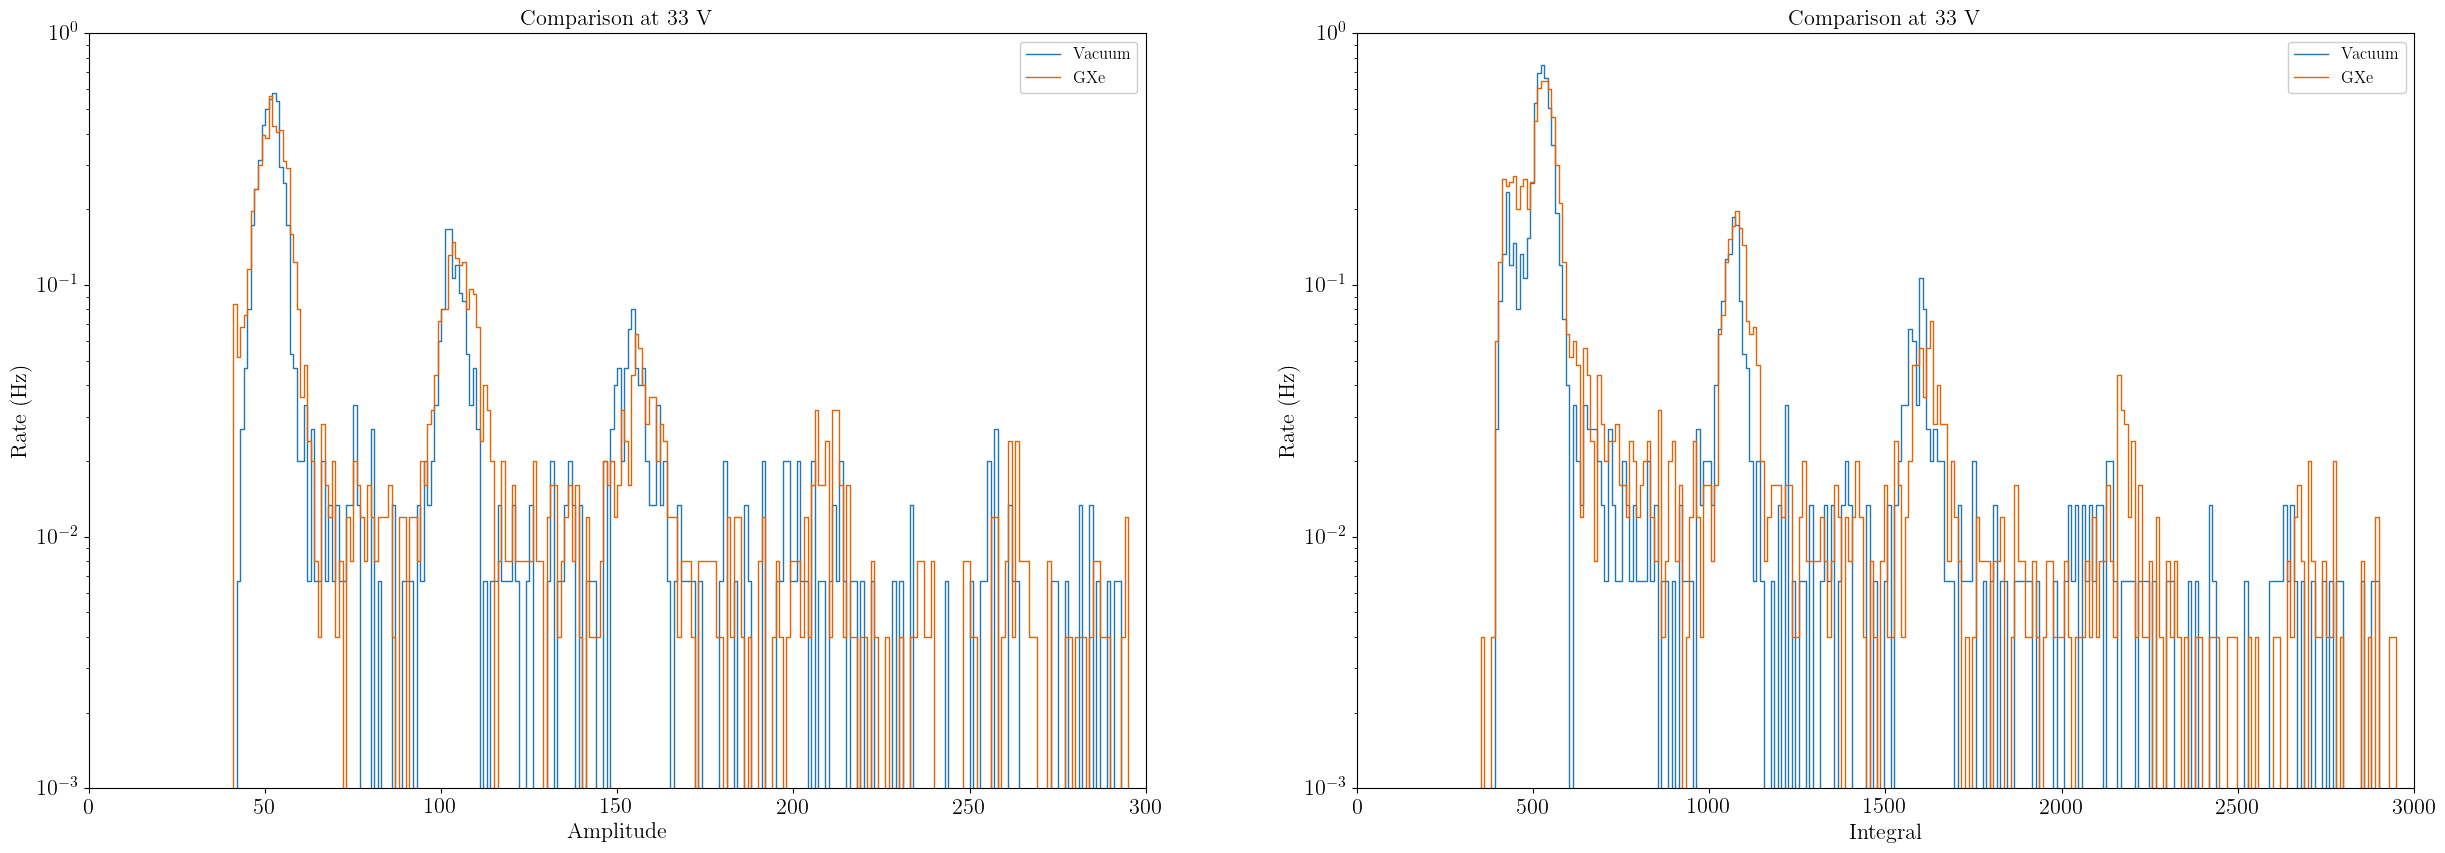

In [56]:
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.step(hx_vacuum[:-1], h_vacuum*vacuum_freq, lw=1,label='Vacuum')
plt.step(hx_GXe[:-1], h_GXe*GXe_freq, lw=1,label='GXe')
plt.xlabel('Amplitude')
plt.ylabel('Rate (Hz)')
plt.yscale('log')
# plt.ylim(0.1,300)
plt.title('Comparison at 33 V')
plt.legend(loc=1)


plt.subplot(1,2,2)
plt.step(hx_vacuum_integral[:-1], h_vacuum_integral*vacuum_freq, lw=1,label='Vacuum')
plt.step(hx_GXe_integral[:-1], h_GXe_integral*GXe_freq, lw=1,label='GXe')
plt.xlabel('Integral')
plt.ylabel('Rate (Hz)')
plt.title('Comparison at 33 V')
plt.yscale('log')
plt.legend(loc=1)

plt.show()

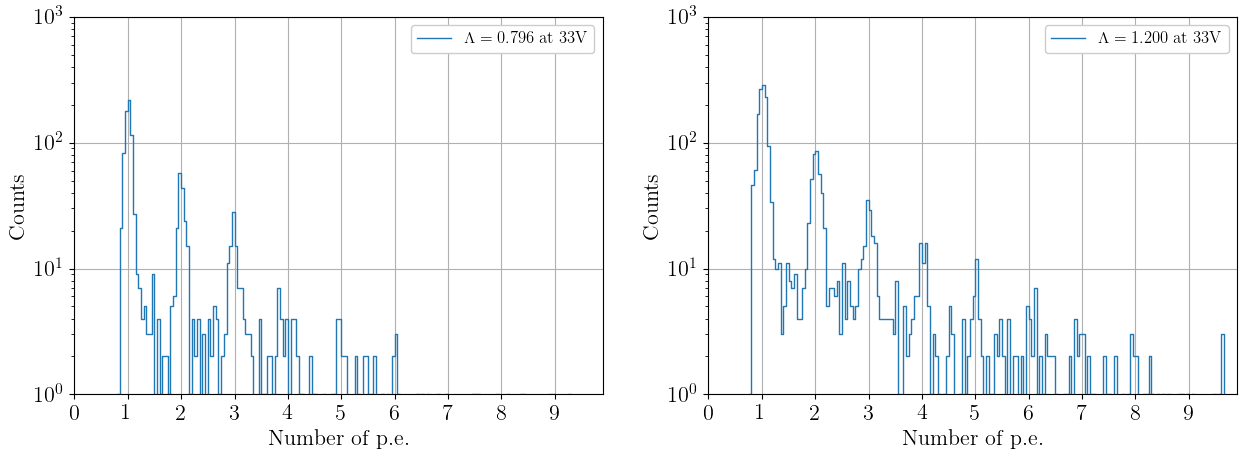

In [57]:
peak_height_calib_vacuum = np.array(peak_heights_vacuum)/np.mean(gain_vacuum)
ca_vacuum = (np.mean(peak_height_calib_vacuum) - 1)
ca_list_vacuum.append(ca_vacuum)
Yale_ca_RMS_vacuum.append(np.sqrt(np.mean(np.square(peak_height_calib_vacuum)))-1)
Yale_ca_err_vacuum.append(np.std(peak_height_calib_vacuum)/np.sqrt(len(peak_height_calib_vacuum)))


peak_height_calib_GXe = np.array(peak_heights_GXe)/np.mean(gain_GXe)
ca_GXe = (np.mean(peak_height_calib_GXe) - 1)
ca_list_GXe.append(ca_GXe)
Yale_ca_RMS_GXe.append(np.sqrt(np.mean(np.square(peak_height_calib_GXe)))-1)
Yale_ca_err_GXe.append(np.std(peak_height_calib_GXe)/np.sqrt(len(peak_height_calib_GXe)))


h_vacuum,hx_vacuum = np.histogram(peak_height_calib_vacuum, bins=np.arange(0,10,0.05))

h_GXe,hx_GXe = np.histogram(peak_height_calib_GXe, bins=np.arange(0,10,0.05))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx_vacuum[:-1], h_vacuum, lw=1, where='post', label='$\Lambda={:.3f}$ at 33V'.format(ca_vacuum))
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx_GXe[:-1], h_GXe, lw=1, where='post', label='$\Lambda={:.3f}$ at 33V'.format(ca_GXe))
plt.legend(loc='upper right')

plt.show()


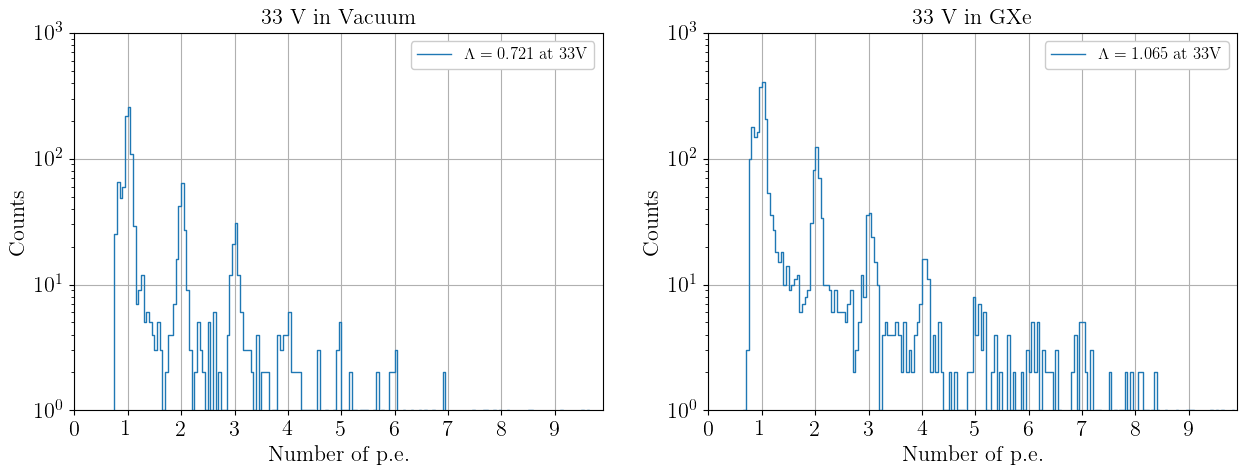

In [58]:
peak_integral_calib_vacuum = np.array(peak_integral_vacuum)/(first_integral_vacuum)
ca_vacuum_integral = (np.mean(peak_integral_calib_vacuum) - 1)
ca_list_vacuum_integral.append(ca_vacuum_integral)
Yale_ca_RMS_vacuum_integral.append(np.sqrt(np.mean(np.square(peak_integral_calib_vacuum)))-1)
Yale_ca_err_vacuum_integral.append(np.std(peak_integral_calib_vacuum)/np.sqrt(len(peak_integral_calib_vacuum)))


peak_integral_calib_GXe = np.array(peak_integral_GXe)/(first_integral_GXe)
ca_GXe_integral = (np.mean(peak_integral_calib_GXe) - 1)
ca_list_GXe_integral.append(ca_GXe_integral)
Yale_ca_RMS_GXe_integral.append(np.sqrt(np.mean(np.square(peak_integral_calib_GXe)))-1)
Yale_ca_err_GXe_integral.append(np.std(peak_integral_calib_GXe)/np.sqrt(len(peak_integral_calib_GXe)))


h_vacuum_integral,hx_vacuum_integral = np.histogram(peak_integral_calib_vacuum, bins=np.arange(0,10,0.05))

h_GXe_integral,hx_GXe_integral = np.histogram(peak_integral_calib_GXe, bins=np.arange(0,10,0.05))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx_vacuum_integral[:-1], h_vacuum_integral, lw=1, where='post', label='$\Lambda={:.3f}$ at 33V'.format(ca_vacuum_integral))
plt.legend(loc='upper right')
plt.title('33 V in Vacuum')
plt.subplot(1,2,2)
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx_GXe_integral[:-1], h_GXe_integral, lw=1, where='post', label='$\Lambda={:.3f}$ at 33V'.format(ca_GXe_integral))
plt.legend(loc='upper right')
plt.title('33 V in GXe')
plt.show()


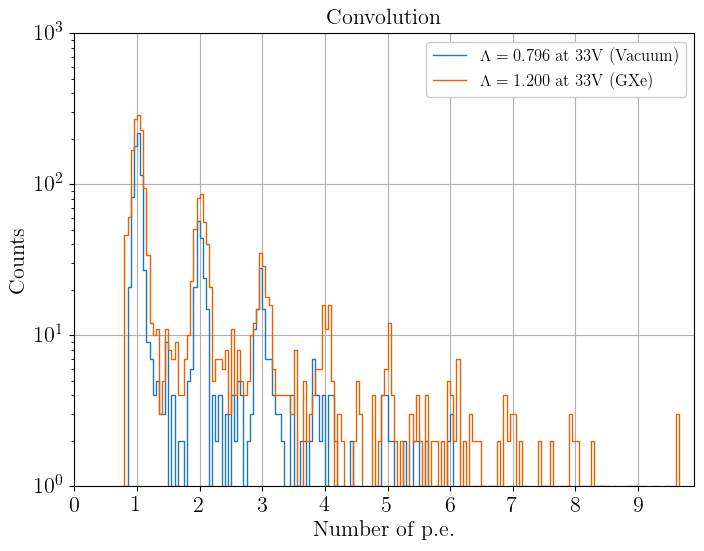

In [59]:
plt.figure(figsize=(8,6))
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx_vacuum[:-1], h_vacuum, lw=1, where='post', label='$\Lambda={:.3f}$ at 33V (Vacuum)'.format(ca_vacuum))
plt.step(hx_GXe[:-1], h_GXe, lw=1, where='post', label='$\Lambda={:.3f}$ at 33V (GXe)'.format(ca_GXe))
plt.legend(loc='upper right')
plt.title('Convolution')
plt.show()

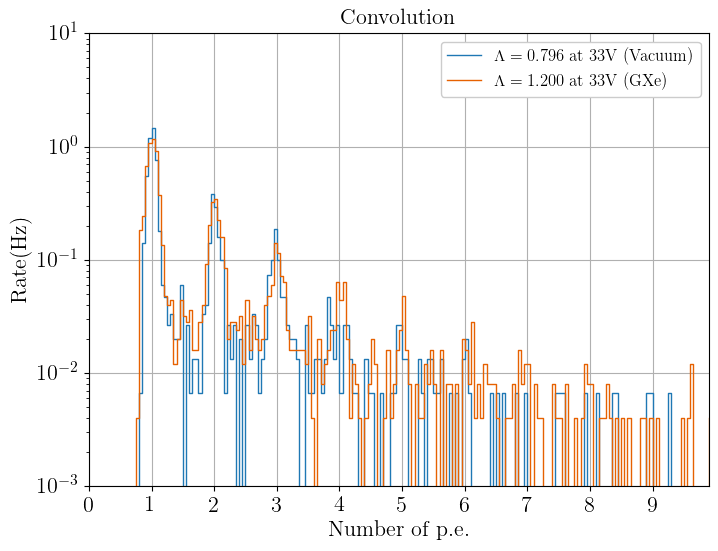

In [60]:
plt.figure(figsize=(8,6))
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Rate(Hz)')
plt.yscale('log')
plt.step(hx_vacuum[:-1], h_vacuum*vacuum_freq, lw=1, where='post', label='$\Lambda={:.3f}$ at 33V (Vacuum)'.format(ca_vacuum))
plt.step(hx_GXe[:-1], h_GXe*GXe_freq, lw=1, where='post', label='$\Lambda={:.3f}$ at 33V (GXe)'.format(ca_GXe))
plt.legend(loc='upper right')
plt.title('Convolution')
plt.show()

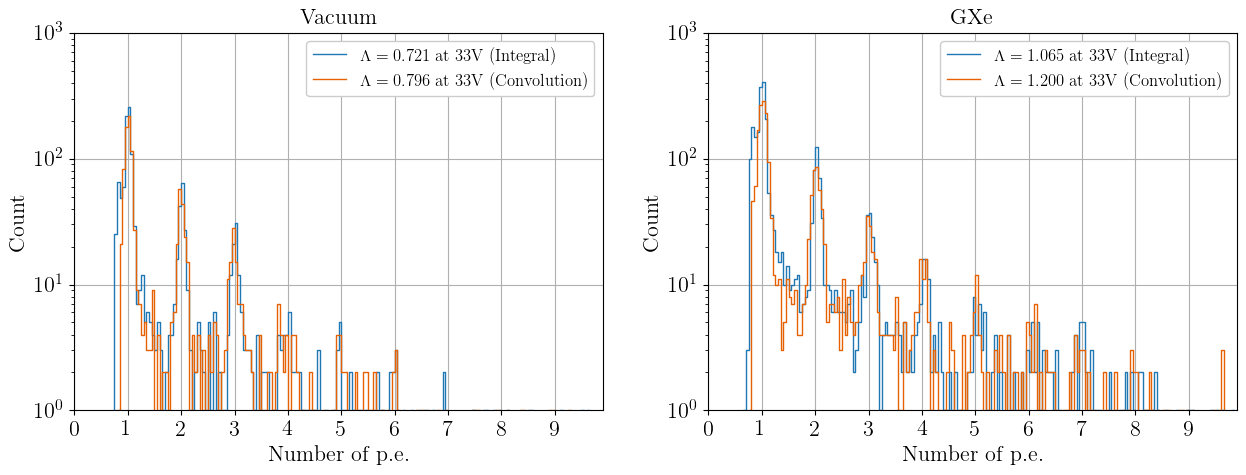

In [61]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Count')
plt.yscale('log')
plt.step(hx_vacuum_integral[:-1], h_vacuum_integral, lw=1, where='post', label='$\Lambda={:.3f}$ at 33V (Integral)'.format(ca_vacuum_integral))
plt.step(hx_vacuum[:-1], h_vacuum, lw=1, where='post', label='$\Lambda={:.3f}$ at 33V (Convolution)'.format(ca_vacuum))
plt.legend(loc='upper right')
plt.title('Vacuum')

plt.subplot(1,2,2)
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Count')
plt.yscale('log')
plt.step(hx_GXe_integral[:-1], h_GXe_integral, lw=1, where='post', label='$\Lambda={:.3f}$ at 33V (Integral)'.format(ca_GXe_integral))
plt.step(hx_GXe[:-1], h_GXe, lw=1, where='post', label='$\Lambda={:.3f}$ at 33V (Convolution)'.format(ca_GXe))
plt.legend(loc='upper right')
plt.title('GXe')

plt.show()

In [62]:
data_vacuum = SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/', 
                    Selection='*DCR_34V*.h5')
data_vacuum.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

for i,File in enumerate(natsorted(data_vacuum.Files)):

    print(i,File)
#     print('Getting data...')
    data_vacuum.ImportDataFromHDF5(File, data_vacuum.Ch)
    
    
data_GXe = SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211202_needs_check/', 
                    Selection='*DCR_34V*.h5')
data_GXe.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

for i,File in enumerate(natsorted(data_GXe.Files)):

    print(i,File)
#     print('Getting data...')
    data_GXe.ImportDataFromHDF5(File, data_GXe.Ch)
    
    
vacuum_freq=1/(100e-3*100*len(natsorted(data_vacuum.Files)))
GXe_freq=1/(100e-3*100*len(natsorted(data_GXe.Files)))

0 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_34V_0.h5
1 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_34V_1.h5
2 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_34V_2.h5
3 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_34V_3.h5
4 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_34V_4.h5
5 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_34V_5.h5
6 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_34V_6.h5
7 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_34V_7.h5
8 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_34V_8.h5
9 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_34V_9.h5
10 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211203/GXe_SiPM_DCR_34V_10.h5
0 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211202_

In [63]:
data=data_vacuum.Ch[0].Amp
time=data_vacuum.Ch[0].Time
scale=data_vacuum.Ch[0].TScale
order=3
lowfreq=100
highfreq=100000
band_type='band'
sampling_time=data_vacuum.Ch[0].Time[1]-data_vacuum.Ch[0].Time[0]
mode='same'
Height=55
Distance=1

In [64]:
peak_heights_vacuum=peak_finding(Height,Distance)

peak_integral_vacuum=peak_integral(Height,Distance)

h_vacuum,hx_vacuum = np.histogram(peak_heights_vacuum, bins=np.arange(0,300,1))

h_vacuum_integral,hx_vacuum_integral = np.histogram(peak_integral_vacuum, bins=np.linspace(0,3000,300))


pe_vacuum = np.median(peak_heights_vacuum)

median_integral_vacuum=np.median(peak_integral_vacuum)




In [65]:
data=data_GXe.Ch[0].Amp
time=data_GXe.Ch[0].Time
scale=data_GXe.Ch[0].TScale
order=3
lowfreq=100
highfreq=100000
band_type='band'
sampling_time=data_GXe.Ch[0].Time[1]-data_GXe.Ch[0].Time[0]
mode='same'
Height=55
Distance=1

In [66]:
peak_heights_GXe=peak_finding(Height,Distance)

h_GXe,hx_GXe = np.histogram(peak_heights_GXe, bins=np.arange(0,300,1))
pe_GXe = np.median(peak_heights_GXe)



peak_integral_GXe=peak_integral(Height,Distance)

h_GXe_integral,hx_GXe_integral = np.histogram(peak_integral_GXe, bins=np.linspace(0,3000,300))

median_integral_GXe=np.median(peak_integral_GXe)

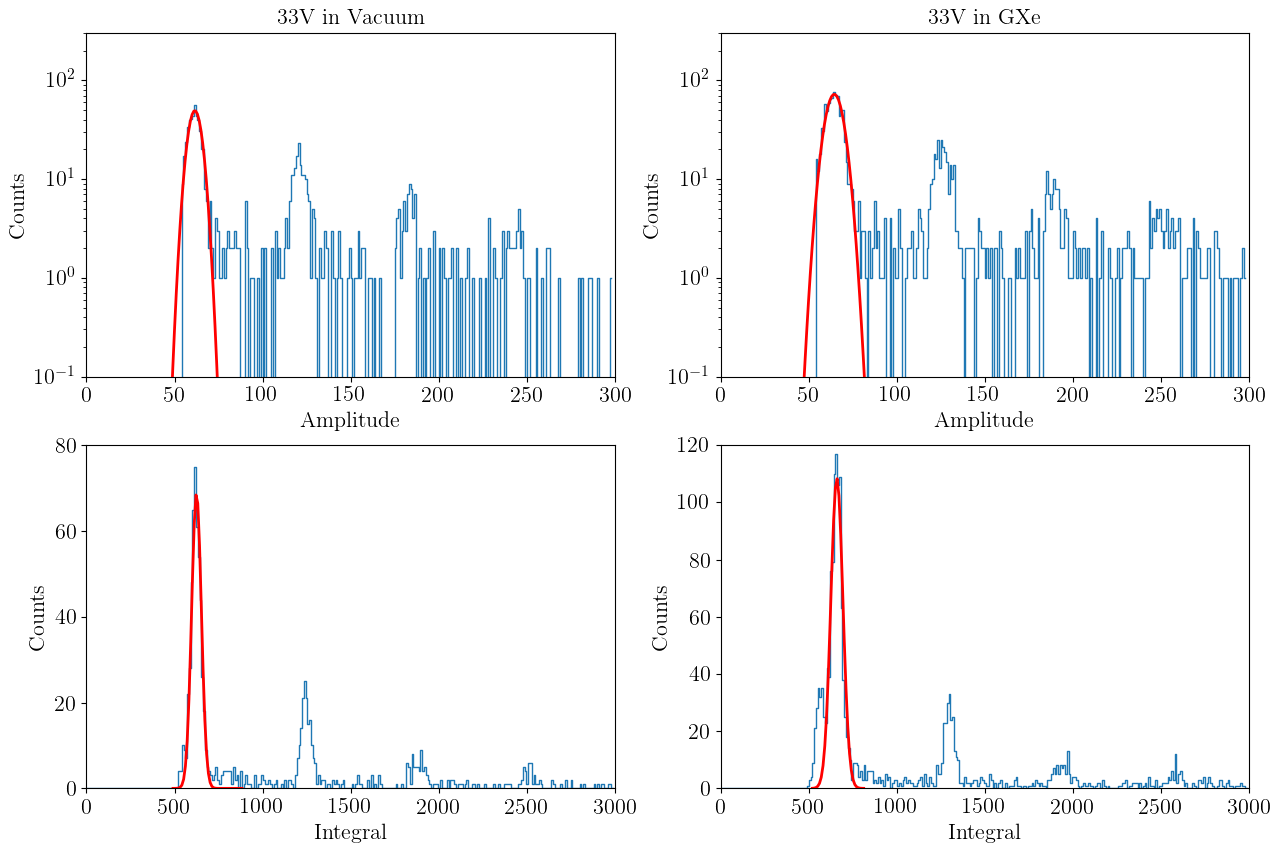

In [67]:
def gauss_func(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))



plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
for i in range(1,2):
    cut_vacuum = np.where((hx_vacuum[:-1]>pe_vacuum*i-50) & (hx_vacuum[:-1]<pe_vacuum*i+(50)))
    
    popt_vacuum,pcov_vacuum = curve_fit(gauss_func, hx_vacuum[:-1][cut_vacuum], h_vacuum[cut_vacuum], 
                          p0=[np.max(h_vacuum[cut_vacuum]), pe_vacuum*i,10],maxfev=100000)

    plt.plot(hx_vacuum[:-1][cut_vacuum], gauss_func(hx_vacuum[:-1][cut_vacuum], *popt_vacuum), color='r', zorder=10)
    plt.step(hx_vacuum[:-1], h_vacuum, lw=1)
    plt.xlabel('Amplitude')
    plt.ylabel('Counts')
    plt.yscale('log')
    plt.ylim(0.1,300)
    plt.title('34V in Vacuum')
plt.subplot(2,2,2)
for i in range(1,2):
    cut_GXe = np.where((hx_GXe[:-1]>pe_GXe*i-50) & (hx_GXe[:-1]<pe_GXe*i+(50)))
    
    popt_GXe,pcov_GXe = curve_fit(gauss_func, hx_GXe[:-1][cut_GXe], h_GXe[cut_GXe], 
                          p0=[np.max(h_GXe[cut_GXe]), pe_GXe*i,10],maxfev=100000)

    plt.plot(hx_GXe[:-1][cut_GXe], gauss_func(hx_GXe[:-1][cut_GXe], *popt_GXe), color='r', zorder=10)
    plt.step(hx_GXe[:-1], h_GXe, lw=1)
    plt.xlabel('Amplitude')
    plt.ylabel('Counts')
    plt.yscale('log')
    plt.ylim(0.1,300)
    plt.title('34V in GXe')

plt.subplot(2,2,3)

BINS=np.linspace(0,1000,100)
cut_vacuum_integral=np.where((hx_vacuum_integral[:-1]<median_integral_vacuum+100) & (hx_vacuum_integral[:-1]>median_integral_vacuum-300))
# plt.hist(peak_integral_10,bins=BINS,lw=1,histtype='step',label='-1 $\mu$s to 10 $\mu$s')
popt_vacuum_integral,pcov_vacuum_integral=curve_fit(gauss_func,hx_vacuum_integral[:-1][:-1][cut_vacuum_integral],h_vacuum_integral[:-1][cut_vacuum_integral],p0=[np.max(h_vacuum_integral[:-1][cut_vacuum_integral]),median_integral_vacuum,10],maxfev=100000)
plt.plot(hx_vacuum_integral[:-1][cut_vacuum_integral],gauss_func(hx_vacuum_integral[:-1][cut_vacuum_integral],*popt_vacuum_integral),color='r', zorder=10)
plt.step(hx_vacuum_integral[:-1], h_vacuum_integral, lw=1)
plt.xlabel('Integral')
plt.ylabel('Counts')




plt.subplot(2,2,4)

cut_GXe_integral=np.where((hx_GXe_integral[:-1]<median_integral_GXe+100) & (hx_GXe_integral[:-1]>median_integral_GXe-200))
# plt.hist(peak_integral_10,bins=BINS,lw=1,histtype='step',label='-1 $\mu$s to 10 $\mu$s')
popt_GXe_integral,pcov_GXe_integral=curve_fit(gauss_func,hx_GXe_integral[:-1][:-1][cut_GXe_integral],h_GXe_integral[:-1][cut_GXe_integral],p0=[np.max(h_GXe_integral[:-1][cut_GXe_integral]),median_integral_GXe,10],maxfev=100000)
plt.plot(hx_GXe_integral[:-1][cut_GXe_integral],gauss_func(hx_GXe_integral[:-1][cut_GXe_integral],*popt_GXe_integral),color='r', zorder=10)
plt.step(hx_GXe_integral[:-1], h_GXe_integral, lw=1)
plt.xlabel('Integral')
plt.ylabel('Counts')




plt.show()




gain_vacuum=popt_vacuum[1]
gain_list_vacuum.append(gain_vacuum)
gain_err_vacuum=np.sqrt(np.diag(pcov_vacuum))
gain_err_list_vacuum.append(gain_err_vacuum[1])

gain_GXe=popt_GXe[1]
gain_list_GXe.append(gain_GXe)
gain_err_GXe=np.sqrt(np.diag(pcov_GXe))
gain_err_list_GXe.append(gain_err_GXe[1])



first_integral_vacuum=popt_vacuum_integral[1]
integral_list_vacuum.append(first_integral_vacuum)
integral_err_vacuum=np.sqrt(np.diag(pcov_vacuum_integral))
integral_err_list_vacuum.append(integral_err_vacuum[1])
  

first_integral_GXe=popt_GXe_integral[1]
integral_list_GXe.append(first_integral_GXe)
integral_err_GXe=np.sqrt(np.diag(pcov_GXe_integral))
integral_err_list_GXe.append(integral_err_GXe[1])


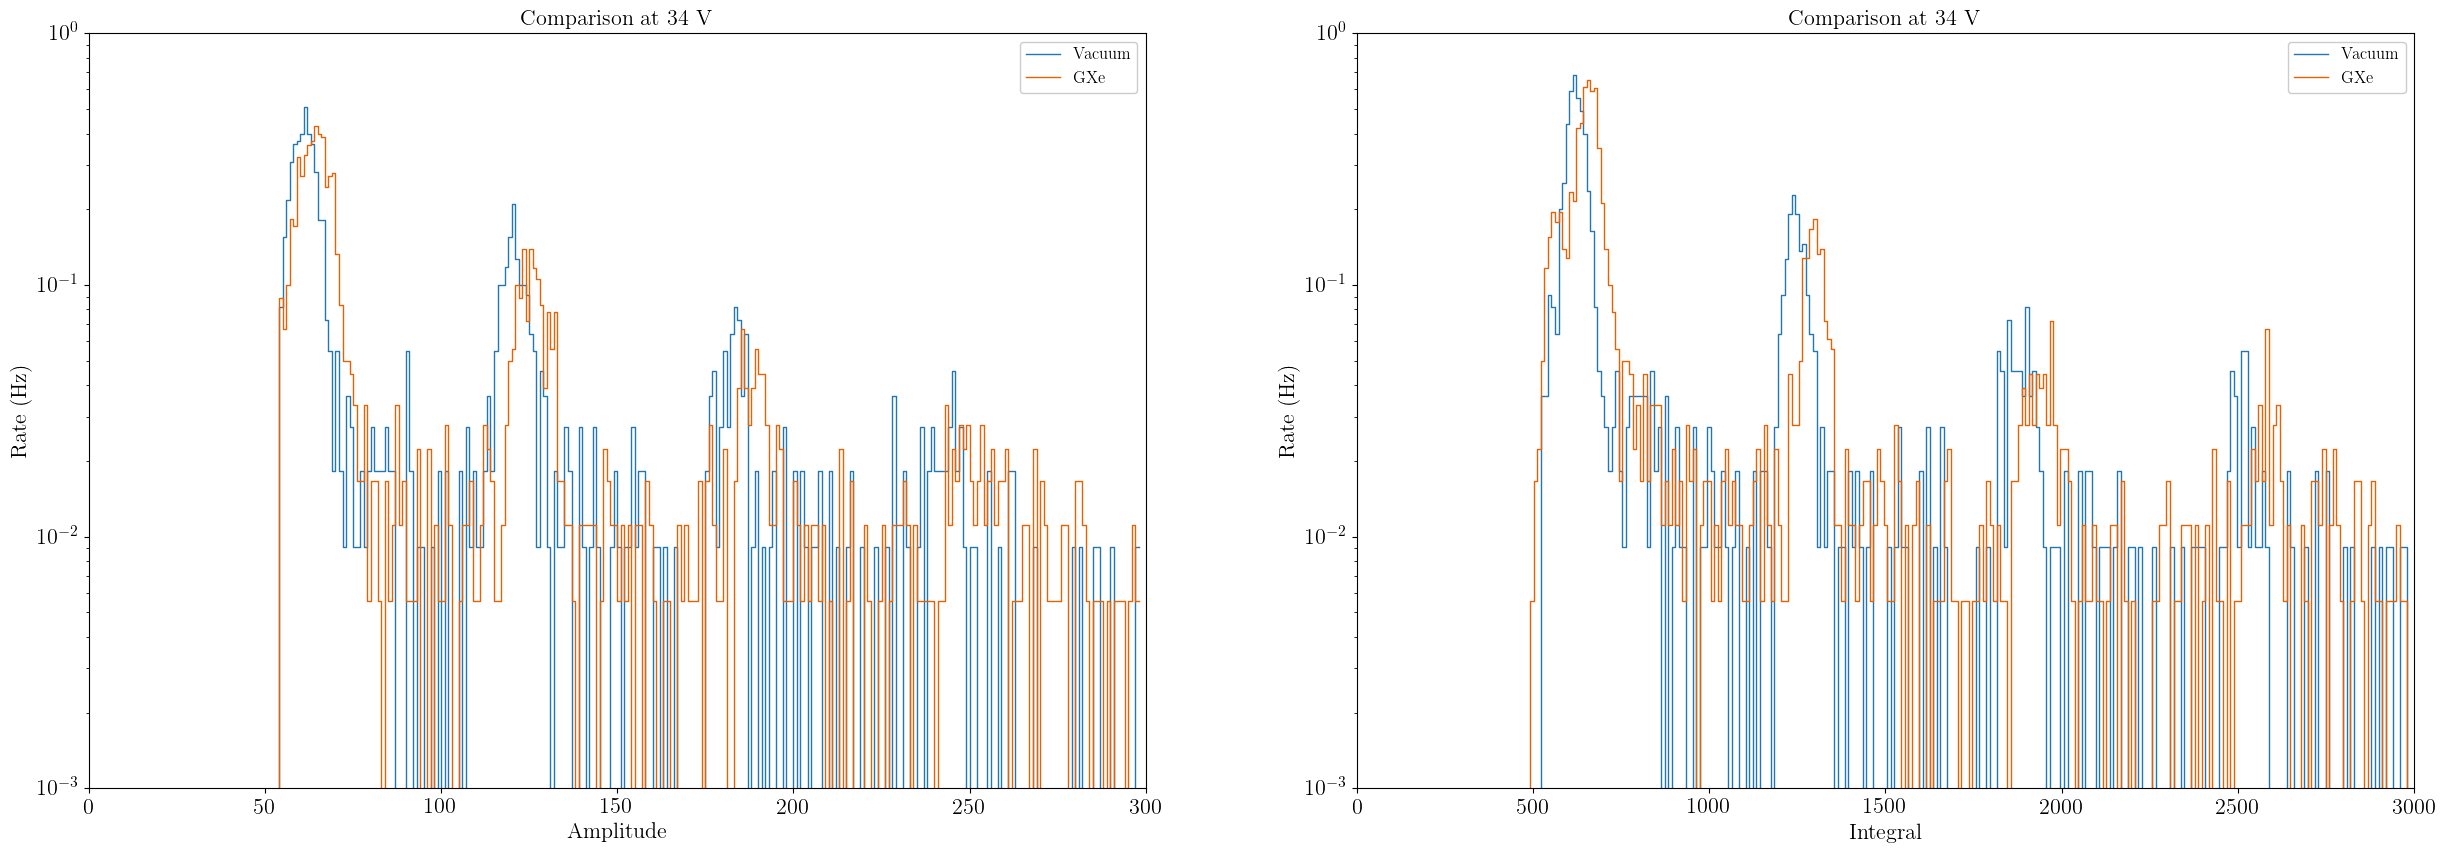

In [68]:
plt.figure(figsize=(30,10))

plt.subplot(1,2,1)
plt.step(hx_vacuum[:-1], h_vacuum*vacuum_freq, lw=1,label='Vacuum')
plt.step(hx_GXe[:-1], h_GXe*GXe_freq, lw=1,label='GXe')
plt.xlabel('Amplitude')
plt.ylabel('Rate (Hz)')
plt.yscale('log')
# plt.ylim(0.1,300)
plt.title('Comparison at 34 V')
plt.legend(loc=1)


plt.subplot(1,2,2)
plt.step(hx_vacuum_integral[:-1], h_vacuum_integral*vacuum_freq, lw=1,label='Vacuum')
plt.step(hx_GXe_integral[:-1], h_GXe_integral*GXe_freq, lw=1,label='GXe')
plt.xlabel('Integral')
plt.ylabel('Rate (Hz)')
plt.title('Comparison at 34 V')
plt.yscale('log')
plt.legend(loc=1)

plt.show()

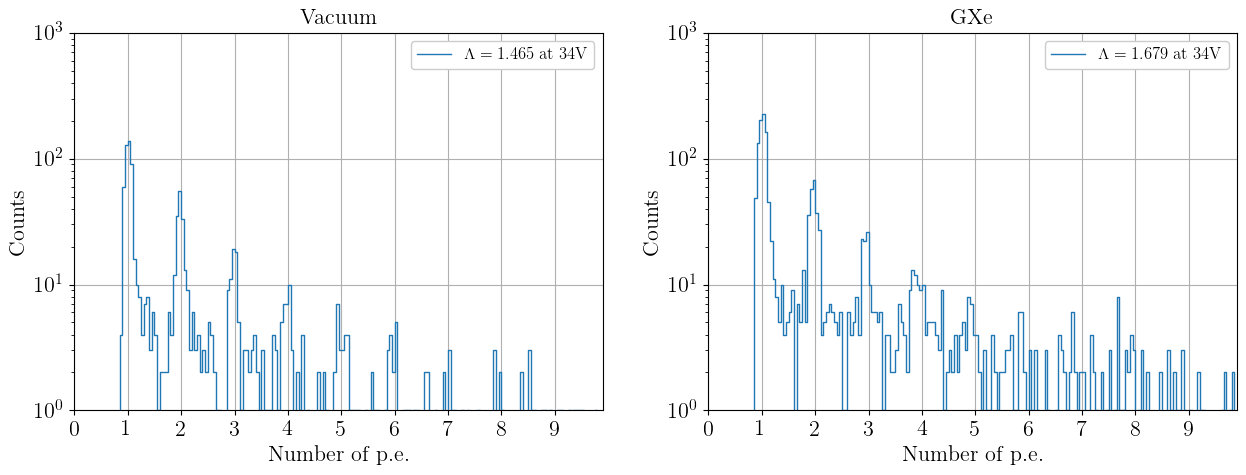

In [69]:
peak_height_calib_vacuum = np.array(peak_heights_vacuum)/np.mean(gain_vacuum)
ca_vacuum = (np.mean(peak_height_calib_vacuum) - 1)
ca_list_vacuum.append(ca_vacuum)
Yale_ca_RMS_vacuum.append(np.sqrt(np.mean(np.square(peak_height_calib_vacuum)))-1)
Yale_ca_err_vacuum.append(np.std(peak_height_calib_vacuum)/np.sqrt(len(peak_height_calib_vacuum)))


peak_height_calib_GXe = np.array(peak_heights_GXe)/np.mean(gain_GXe)
ca_GXe = (np.mean(peak_height_calib_GXe) - 1)
ca_list_GXe.append(ca_GXe)
Yale_ca_RMS_GXe.append(np.sqrt(np.mean(np.square(peak_height_calib_GXe)))-1)
Yale_ca_err_GXe.append(np.std(peak_height_calib_GXe)/np.sqrt(len(peak_height_calib_GXe)))


h_vacuum,hx_vacuum = np.histogram(peak_height_calib_vacuum, bins=np.arange(0,10,0.05))

h_GXe,hx_GXe = np.histogram(peak_height_calib_GXe, bins=np.arange(0,10,0.05))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx_vacuum[:-1], h_vacuum, lw=1, where='post', label='$\Lambda={:.3f}$ at 34V'.format(ca_vacuum))
plt.legend(loc='upper right')
plt.title('Vacuum')
plt.subplot(1,2,2)
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx_GXe[:-1], h_GXe, lw=1, where='post', label='$\Lambda={:.3f}$ at 34V'.format(ca_GXe))
plt.legend(loc='upper right')
plt.title('GXe')
plt.show()

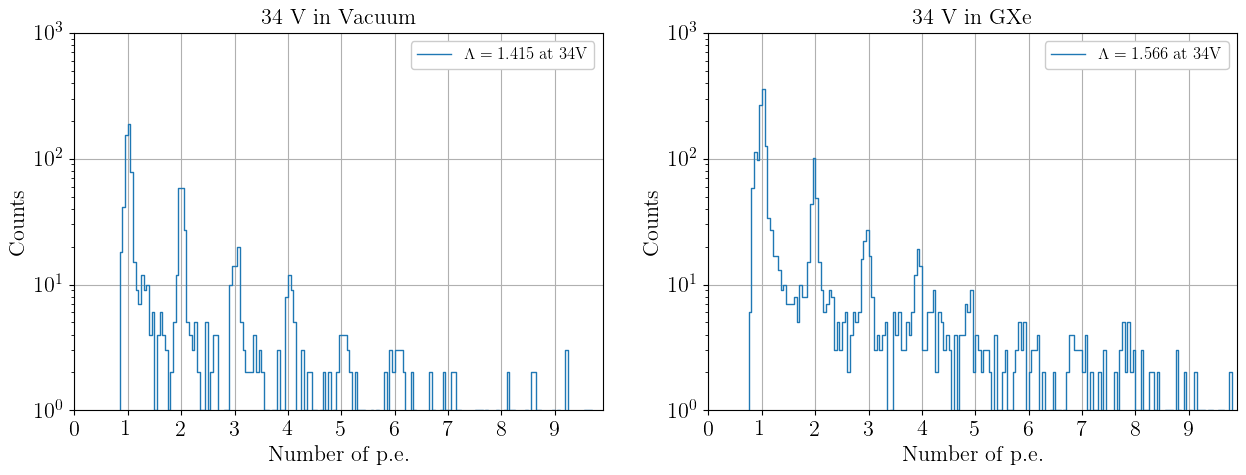

In [70]:
peak_integral_calib_vacuum = np.array(peak_integral_vacuum)/(first_integral_vacuum)
ca_vacuum_integral = (np.mean(peak_integral_calib_vacuum) - 1)
ca_list_vacuum_integral.append(ca_vacuum_integral)
Yale_ca_RMS_vacuum_integral.append(np.sqrt(np.mean(np.square(peak_integral_calib_vacuum)))-1)
Yale_ca_err_vacuum_integral.append(np.std(peak_integral_calib_vacuum)/np.sqrt(len(peak_integral_calib_vacuum)))


peak_integral_calib_GXe = np.array(peak_integral_GXe)/(first_integral_GXe)
ca_GXe_integral = (np.mean(peak_integral_calib_GXe) - 1)
ca_list_GXe_integral.append(ca_GXe_integral)
Yale_ca_RMS_GXe_integral.append(np.sqrt(np.mean(np.square(peak_integral_calib_GXe)))-1)
Yale_ca_err_GXe_integral.append(np.std(peak_integral_calib_GXe)/np.sqrt(len(peak_integral_calib_GXe)))


h_vacuum_integral,hx_vacuum_integral = np.histogram(peak_integral_calib_vacuum, bins=np.arange(0,10,0.05))

h_GXe_integral,hx_GXe_integral = np.histogram(peak_integral_calib_GXe, bins=np.arange(0,10,0.05))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx_vacuum_integral[:-1], h_vacuum_integral, lw=1, where='post', label='$\Lambda={:.3f}$ at 34V'.format(ca_vacuum_integral))
plt.legend(loc='upper right')
plt.title('34 V in Vacuum')
plt.subplot(1,2,2)
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx_GXe_integral[:-1], h_GXe_integral, lw=1, where='post', label='$\Lambda={:.3f}$ at 34V'.format(ca_GXe_integral))
plt.legend(loc='upper right')
plt.title('34 V in GXe')
plt.show()


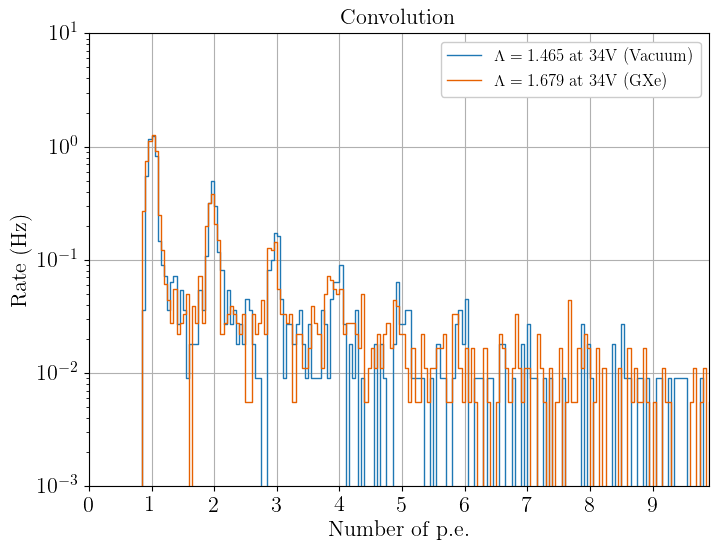

In [71]:
plt.figure(figsize=(8,6))
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Rate (Hz)')
plt.yscale('log')
plt.step(hx_vacuum[:-1], h_vacuum*vacuum_freq, lw=1, where='post', label='$\Lambda={:.3f}$ at 34V (Vacuum)'.format(ca_vacuum))
plt.step(hx_GXe[:-1], h_GXe*GXe_freq, lw=1, where='post', label='$\Lambda={:.3f}$ at 34V (GXe)'.format(ca_GXe))
plt.legend(loc='upper right')
plt.title('Convolution')
plt.show()

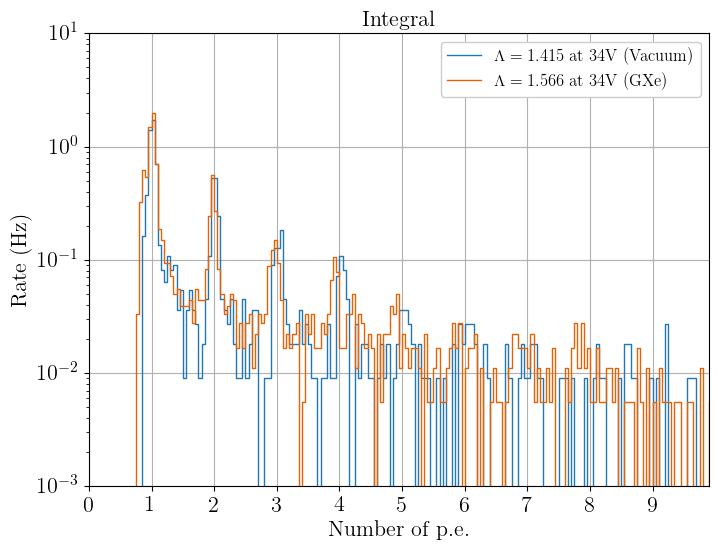

In [72]:
plt.figure(figsize=(8,6))
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Rate (Hz)')
plt.yscale('log')
plt.title('Integral')
plt.step(hx_vacuum_integral[:-1], h_vacuum_integral*vacuum_freq, lw=1, where='post', label='$\Lambda={:.3f}$ at 34V (Vacuum)'.format(ca_vacuum_integral))
plt.step(hx_GXe_integral[:-1], h_GXe_integral*GXe_freq, lw=1, where='post', label='$\Lambda={:.3f}$ at 34V (GXe)'.format(ca_GXe_integral))
plt.legend(loc='upper right')
plt.show()

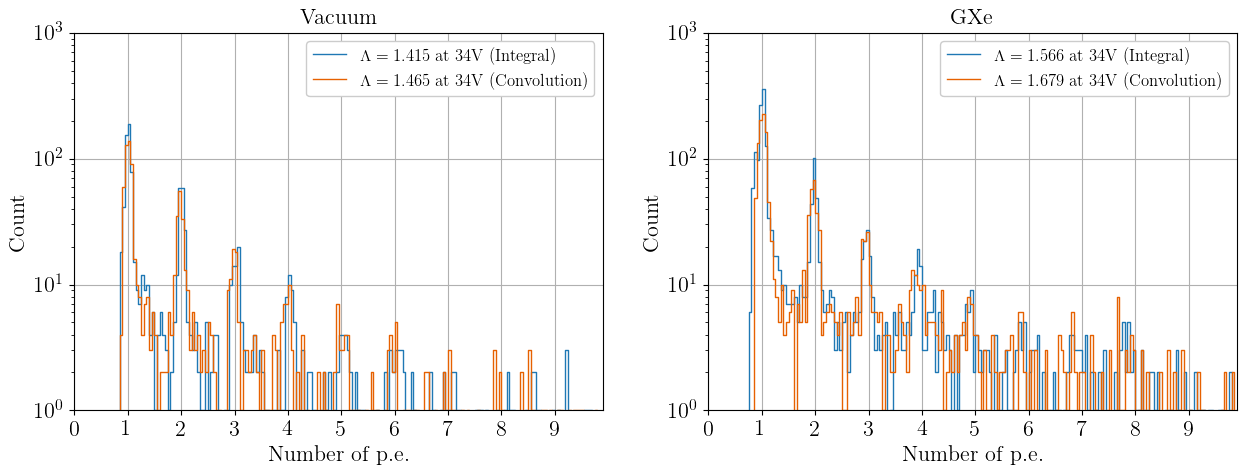

In [73]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Count')
plt.yscale('log')
plt.step(hx_vacuum_integral[:-1], h_vacuum_integral, lw=1, where='post', label='$\Lambda={:.3f}$ at 34V (Integral)'.format(ca_vacuum_integral))
plt.step(hx_vacuum[:-1], h_vacuum, lw=1, where='post', label='$\Lambda={:.3f}$ at 34V (Convolution)'.format(ca_vacuum))
plt.legend(loc='upper right')
plt.title('Vacuum')

plt.subplot(1,2,2)
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Count')
plt.yscale('log')
plt.step(hx_GXe_integral[:-1], h_GXe_integral, lw=1, where='post', label='$\Lambda={:.3f}$ at 34V (Integral)'.format(ca_GXe_integral))
plt.step(hx_GXe[:-1], h_GXe, lw=1, where='post', label='$\Lambda={:.3f}$ at 34V (Convolution)'.format(ca_GXe))
plt.legend(loc='upper right')
plt.title('GXe')

plt.show()

In [74]:
print(gain_list_GXe)
print(gain_err_list_GXe)

[23.022874558331534, 33.10163431050145, 42.29487039983767, 52.524326666151836, 64.57746285707734]
[0.05636275162582166, 0.061903176009707093, 0.054496559487837735, 0.14353915451962032, 0.21928851929485957]


[2.29459217 3.29459217 4.29459217 5.29459217 6.29459217]
0.04868228943852794
[2.33538868 3.33538868 4.33538868 5.33538868 6.33538868]
0.08862797803160809


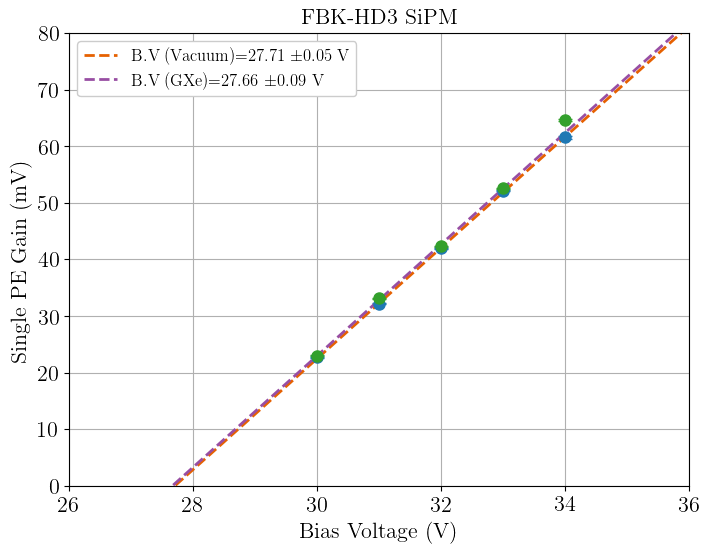

In [75]:
def func_line(x,a,b):
    return (x-a)*b
fig=plt.figure(figsize=(8,6))
x_data=np.linspace(26,36,100)
bv_list=[30,31,32,33,34]
plt.errorbar(bv_list,gain_list_vacuum,yerr=gain_err_list_vacuum,fmt='o',ms=8)
popt_vacuum,pcov_vacuum=curve_fit(func_line,bv_list,gain_list_vacuum,p0=[27.5,0.2],sigma=gain_err_list_vacuum,maxfev=100000)
plt.plot(x_data,func_line(x_data,*popt_vacuum),'--',label='B.V (Vacuum)={:.2f} $\pm${:.2f} V'.format(popt_vacuum[0],np.sqrt(np.diag(pcov_vacuum))[0]))


plt.errorbar(bv_list,gain_list_GXe,yerr=gain_err_list_GXe,fmt='o',ms=8)
popt_GXe,pcov_GXe=curve_fit(func_line,bv_list,gain_list_GXe,p0=[27.5,0.2],sigma=gain_err_list_GXe,maxfev=100000)
plt.plot(x_data,func_line(x_data,*popt_GXe),'--',label='B.V (GXe)={:.2f} $\pm${:.2f} V'.format(popt_GXe[0],np.sqrt(np.diag(pcov_GXe))[0]))



plt.xlabel('Bias Voltage (V)')
plt.ylabel('Single PE Gain (mV)')
plt.legend(loc=2)
plt.xlim(26,36)
plt.ylim(0,80)
plt.title('FBK-HD3 SiPM')
plt.grid()
# plt.savefig('gainvsbias.pdf')

breakdown_V_vacuum=popt_vacuum[0]

breakdown_V_GXe=popt_GXe[0]


ov_list_vacuum=bv_list-breakdown_V_vacuum
print(ov_list_vacuum)
Yale_bv_err_vacuum=np.sqrt(np.diag(pcov_vacuum))[0]
print(Yale_bv_err_vacuum)


ov_list_GXe=bv_list-breakdown_V_GXe
print(ov_list_GXe)
Yale_bv_err_GXe=np.sqrt(np.diag(pcov_GXe))[0]
print(Yale_bv_err_GXe)

# plt.savefig('gain_bv.pdf')
plt.show()

[2.35522275 3.35522275 4.35522275 5.35522275 6.35522275]
0.04792674274473331
[2.32675852 3.32675852 4.32675852 5.32675852 6.32675852]
0.08559310473101502


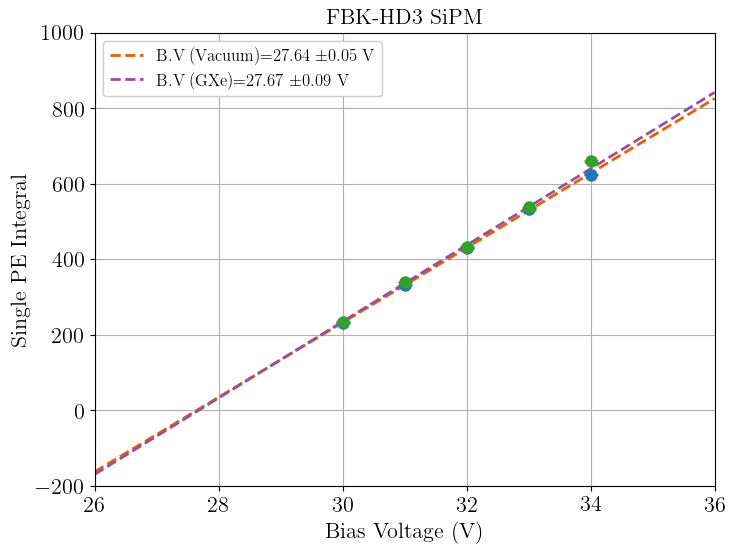

In [76]:
def func_line(x,a,b):
    return (x-a)*b
fig=plt.figure(figsize=(8,6))
x_data=np.linspace(26,36,100)
bv_list=[30,31,32,33,34]
plt.errorbar(bv_list,integral_list_vacuum,yerr=integral_err_list_vacuum,fmt='o',ms=8)
popt_vacuum,pcov_vacuum=curve_fit(func_line,bv_list,integral_list_vacuum,p0=[27.5,0.2],sigma=integral_err_list_vacuum,maxfev=100000)
plt.plot(x_data,func_line(x_data,*popt_vacuum),'--',label='B.V (Vacuum)={:.2f} $\pm${:.2f} V'.format(popt_vacuum[0],np.sqrt(np.diag(pcov_vacuum))[0]))


plt.errorbar(bv_list,integral_list_GXe,yerr=integral_err_list_GXe,fmt='o',ms=8)
popt_GXe,pcov_GXe=curve_fit(func_line,bv_list,integral_list_GXe,p0=[27.5,0.2],sigma=gain_err_list_GXe,maxfev=100000)
plt.plot(x_data,func_line(x_data,*popt_GXe),'--',label='B.V (GXe)={:.2f} $\pm${:.2f} V'.format(popt_GXe[0],np.sqrt(np.diag(pcov_GXe))[0]))



plt.xlabel('Bias Voltage (V)')
plt.ylabel('Single PE Integral ')
plt.legend(loc=2)
# plt.xlim(26,36)
# plt.ylim(0,80)
plt.title('FBK-HD3 SiPM')
plt.grid()
# plt.savefig('gainvsbias.pdf')

breakdown_V_vacuum_integral=popt_vacuum[0]

breakdown_V_GXe_integral=popt_GXe[0]


ov_list_vacuum_integral=bv_list-breakdown_V_vacuum_integral
print(ov_list_vacuum_integral)
Yale_bv_err_vacuum_integral=np.sqrt(np.diag(pcov_vacuum))[0]
print(Yale_bv_err_vacuum_integral)


ov_list_GXe_integral=bv_list-breakdown_V_GXe_integral
print(ov_list_GXe_integral)
Yale_bv_err_GXe_integral=np.sqrt(np.diag(pcov_GXe))[0]
print(Yale_bv_err_GXe_integral)

plt.savefig('integral_bv.pdf')
plt.show()

In [77]:
df_triumf1=pd.read_csv('nCP_VUVHD3_110_RMS.txt',sep=",",header=None)
# print(df_triumf1)
df_triumf1.columns=['OV','OV_err','TNA','CA','RMS']

df_triumf2=pd.read_csv('nCP_VUVHD3_110_2_RMS.txt',sep=",",header=None)
df_triumf2.columns=['OV','OV_err','TNA','CA','RMS']

df_triumf3=pd.read_csv('nCP_VUVHD3_110_2_RMS.txt',sep=",",header=None)
df_triumf3.columns=['OV','OV_err','TNA','CA','RMS']

df_HEP=pd.read_csv('nCP_VUVHD3_iHEP_50C.txt',sep=",",header=None)

df_HEP.columns=['OV','OV_err','CA','CA_err','RMS']

BNL_OV=[0.87,1.87,2.87,3.87,4.87,5.87,6.87]
BNL_ca=[0.085,0.15,0.301,0.543,0.8327,1.327,2.17]
BNL_ca_RMS=[]

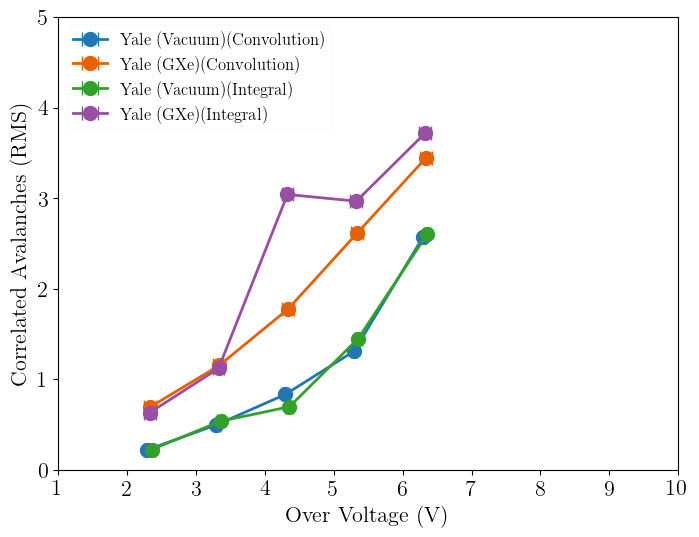

In [87]:
plt.figure(figsize=(8,6))

# plt.errorbar(df_triumf1['OV'],df_triumf1['RMS'],fmt='-v',label='TRIUMF Device 1')
# plt.errorbar(df_triumf2['OV'],df_triumf2['RMS'],fmt='-v',label='TRIUMF Device 2')
# plt.errorbar(df_triumf3['OV'],df_triumf3['RMS'],fmt='-v',label='TRIUMF Device 3')
# plt.errorbar(df_HEP['OV'],df_HEP['RMS'],label='IHEP',fmt='-+')
plt.errorbar(ov_list_vacuum,Yale_ca_RMS_vacuum,xerr=Yale_bv_err_vacuum,fmt='-o',label='Yale (Vacuum)(Convolution)')
plt.errorbar(ov_list_GXe,Yale_ca_RMS_GXe,xerr=Yale_bv_err_GXe,fmt='-o',label='Yale (GXe)(Convolution)')
plt.errorbar(ov_list_vacuum_integral,Yale_ca_RMS_vacuum_integral,xerr=Yale_bv_err_vacuum_integral,fmt='-o',label='Yale (Vacuum)(Integral)')
plt.errorbar(ov_list_GXe_integral,Yale_ca_RMS_GXe_integral,xerr=Yale_bv_err_GXe_integral,fmt='-o',label='Yale (GXe)(Integral)')

plt.xlabel('Over Voltage (V)')
plt.ylabel('Correlated Avalanches (RMS)')
plt.xlim(1,10)
plt.ylim(0,5)
plt.legend(loc=2,framealpha=0.1)

plt.savefig('ca_RMS_ov.pdf')
plt.show()

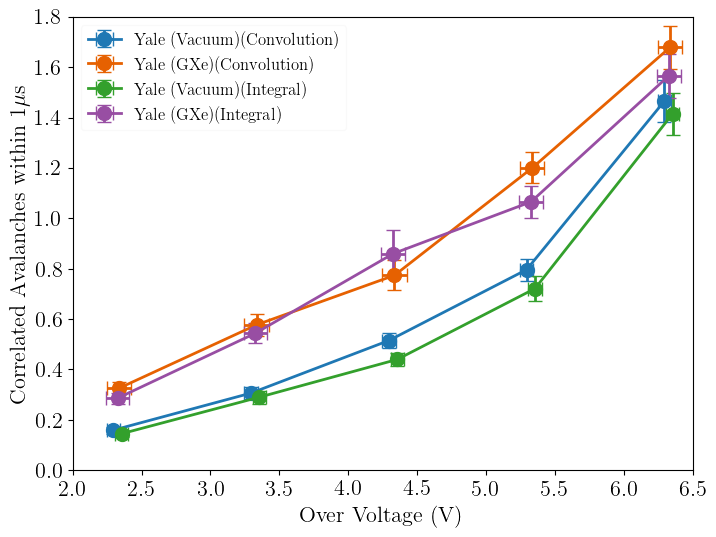

In [86]:
plt.figure(figsize=(8,6))
# plt.errorbar(df_triumf1['OV'],df_triumf1['CA'],xerr=df_triumf1['OV_err'],fmt='-v',label='TRIUMF Device 1')
# plt.errorbar(df_triumf2['OV'],df_triumf2['CA'],xerr=df_triumf2['OV_err'],fmt='-v',label='TRIUMF Device 2')
# plt.errorbar(df_triumf3['OV'],df_triumf3['CA'],xerr=df_triumf3['OV_err'],fmt='-v',label='TRIUMF Device 3')
# plt.errorbar(df_HEP['OV'],df_HEP['CA'],xerr=df_HEP['OV_err'],yerr=df_HEP['CA_err'],label='IHEP')
# plt.errorbar(BNL_OV,BNL_ca,fmt='-*',label='BNL')
plt.errorbar(ov_list_vacuum,ca_list_vacuum,xerr=Yale_bv_err_vacuum,yerr=Yale_ca_err_vacuum,fmt='-o',label='Yale (Vacuum)(Convolution)')
plt.errorbar(ov_list_GXe,ca_list_GXe,xerr=Yale_bv_err_GXe,yerr=Yale_ca_err_GXe,fmt='-o',label='Yale (GXe)(Convolution)')

plt.errorbar(ov_list_vacuum_integral,ca_list_vacuum_integral,xerr=Yale_bv_err_vacuum_integral,yerr=Yale_ca_err_vacuum_integral,fmt='-o',label='Yale (Vacuum)(Integral)')
plt.errorbar(ov_list_GXe_integral,ca_list_GXe_integral,xerr=Yale_bv_err_GXe_integral,yerr=Yale_ca_err_GXe_integral,fmt='-o',label='Yale (GXe)(Integral)')


plt.xlabel('Over Voltage (V)')
plt.ylabel('Correlated Avalanches within 1$\mu$s')
# plt.xlim(0,10)
# plt.ylim(0,2.6)
plt.legend(loc=2,framealpha=0.1)
plt.savefig('ca_ov.pdf')
plt.show()